# <div align="center">   DSI13 Capstone </div>
# <div align="center"> Predicting the Remaining Useful Life of Turbofan Engines  </div>

# Problem Statement

Prognostics is an engineering discipline focused on predicting the time at which a system or a component will no longer perform its intended function. The predicted time then becomes the remaining useful life (RUL), which is an important concept in decision making for contingency mitigation. Prognostics predicts the future performance of a component by assessing the extent of deviation or degradation of a system from its expected normal operating conditions.

Traditional maintenance concept is typically time/schedule based and is a reactive type of maintenance.  On the other hand, condition based maintenance is prognostics-based and a pro-active type of maintenance that relies on early detection and prediction of potential failure of the equipment or component to pre-empt sudden breakdowns and prolonged downtime, resulting in reduced maintenance cost while keeping equipment operationally ready and available.

The aim this project is to build machine learning models capable of forecasting the remaining useful life of turbofan engines (regression model), as well as predicting whether they will fail or not given the operating conditions data (classification model). The output of the models will be computed with a set of maintenance costs to demonstrate the benefits of such pro-active maintenance concept.

# Contents 

- [Data Cleaning and Inspection](#Data-Cleaning-and-Inspection)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing and Modelling](#Preprocessing-and-Modelling)
- [Analysis](#Analysis)
- [Recommendations and Conclusion](#Recommendations-and-Conclusion)

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression,LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=(FutureWarning, UserWarning))

/Users/Dickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Data Cleaning and Inspection

The datasets are in txt format and are obtained from NASA :  
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

There are 4 sets each of training and testing data and true (ground-truth) remaining useful life values for model evaluation available. For this project Dataset 1 will be used. It contains 100 engines' data. The engines can be considered to be from a fleet of the same type. 

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 

The data are provided as text files with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

    1)	unit number
    2)	time, in cycles
    3)	operational setting 1
    4)	operational setting 2
    5)	operational setting 3
    6)	sensor measurement  1
    7)	sensor measurement  2
    ...
    26)	sensor measurement  26

The data details and data dictionary can be found in the readme.md file.

The true remaining useful life (RUL) will be merged into the test dataset.

|Dataset|No. of rows|No. of Engines|
|:---|---|---|
|train_FD001|20631|100|
|test_FD001|13096|100|
|RUL_FD001|100|100|


In [2]:
# Load the train, test and RUL datasets

df1_train = pd.read_csv('./data/train_FD001.txt', sep=' ', header = None)
df1_test = pd.read_csv('./data/test_FD001.txt', sep=' ', header = None)
true_rul1 = pd.read_csv('./data/RUL_FD001.txt', sep='\n', header = None)

In [3]:
# As the headers are in numbers, change the header titles according to the data dictionary

headers=['engine','cycle','op_setting_1','op_setting_2','op_setting_3','sensor_1','sensor_2',
         'sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9',
         'sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16',
         'sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23']

df1_train.columns=headers
df1_test.columns=headers

In [4]:
# Check the shape of the data

print ('train dataset    :', df1_train.shape)
print ('test dataset     :', df1_test.shape)
print ('True RUL dataset :', true_rul1.shape)

train dataset    : (20631, 28)
test dataset     : (13096, 28)
True RUL dataset : (100, 1)


In [5]:
# Check the train dataset

df1_train.head()

engine  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0       1      1       -0.0007       -0.0004         100.0    518.67   
1       1      2        0.0019       -0.0003         100.0    518.67   
2       1      3       -0.0043        0.0003         100.0    518.67   
3       1      4        0.0007        0.0000         100.0    518.67   
4       1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_14  sensor_15  \
0    641.82   1589.70   1400.60     14.62  ...    8138.62     8.4195   
1    642.15   1591.82   1403.14     14.62  ...    8131.49     8.4318   
2    642.35   1587.99   1404.20     14.62  ...    8133.23     8.4178   
3    642.35   1582.79   1401.87     14.62  ...    8133.83     8.3682   
4    642.37   1582.85   1406.22     14.62  ...    8133.80     8.4294   

   sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  \
0       0.03        392       2388      100.0      39.06    23.4190   
1       0.03        392       2388      100.0      39.00    23.4236   
2       0.03        390       2388      100.0      38.95    23.3442   
3       0.03        392       2388      100.0      38.88    23.3739   
4       0.03        393       2388      100.0      38.90    23.4044   

   sensor_22  sensor_23  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

[5 rows x 28 columns]

In [6]:
# Check for null values since data dictionary indicates only sensors from 1 to 21

df1_train.isnull().sum()

engine              0
cycle               0
op_setting_1        0
op_setting_2        0
op_setting_3        0
sensor_1            0
sensor_2            0
sensor_3            0
sensor_4            0
sensor_5            0
sensor_6            0
sensor_7            0
sensor_8            0
sensor_9            0
sensor_10           0
sensor_11           0
sensor_12           0
sensor_13           0
sensor_14           0
sensor_15           0
sensor_16           0
sensor_17           0
sensor_18           0
sensor_19           0
sensor_20           0
sensor_21           0
sensor_22       20631
sensor_23       20631
dtype: int64

In [7]:
# Check the true RUL dataset

true_rul1.head()

0
0  112
1   98
2   69
3   82
4   91

In [8]:
# Change column name of the true RUL datadrames

true_rul1.columns = ['RUL']

In [9]:
# From the data dictionary, there are only 21 sensors, so last 2 sensors columns can be removed

df1_train.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df1_test.drop(['sensor_22','sensor_23'], axis =1, inplace=True)

In [10]:
df1_train.head()

engine  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0       1      1       -0.0007       -0.0004         100.0    518.67   
1       1      2        0.0019       -0.0003         100.0    518.67   
2       1      3       -0.0043        0.0003         100.0    518.67   
3       1      4        0.0007        0.0000         100.0    518.67   
4       1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392       2388      100.0   
1    8131.49     8.4318       0.03        392       2388      100.0   
2    8133.23     8.4178       0.03        390       2388      100.0   
3    8133.83     8.3682       0.03        392       2388      100.0   
4    8133.80     8.4294       0.03        393       2388      100.0   

   sensor_20  sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  
2      38.95    23.3442  
3      38.88    23.3739  
4      38.90    23.4044  

[5 rows x 26 columns]

### Obtain the remaining useful life (RUL) for the dataset

Each engine is run until faults develop. Hence we can assume that the last cycle that the engine is running before it develops faults is equal to zero ie RUL = 0.

For each row in the dataset, the RUL is thus the difference between the maximum cycle in the particular engine minus the current cycle.

In [11]:
# Function to compute the RUL for each engine

# Remaining cycle (RUL) = last cycle - current cycle

def get_rul(df):
    
    # Get the last cycle reached for each engine
    df_cycle = pd.DataFrame(df.groupby('engine')['cycle'].max())
    
    # reset the index so that column names can be added
    df_cycle.reset_index(level = 0, inplace = True)
    df_cycle.columns = ['engine', 'last_cycle']
    
    # Merge the cycle df to the train df in order to calculate RUL
    df_rul = pd.merge(df, df_cycle, on ='engine')
    
    # RUL = last cycle - current cycle.
    df_rul['RUL'] = df_rul['last_cycle'] - df_rul['cycle']
    df_rul.drop(['last_cycle'], axis = 1, inplace = True)
    return df_rul

In [12]:
# Get the RUL for the 4 datasets using the function get_rul

df1_train_ready = get_rul(df1_train)

In [13]:
# Check the RUL column

df1_train_ready.head()

engine  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0       1      1       -0.0007       -0.0004         100.0    518.67   
1       1      2        0.0019       -0.0003         100.0    518.67   
2       1      3       -0.0043        0.0003         100.0    518.67   
3       1      4        0.0007        0.0000         100.0    518.67   
4       1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  \
0    641.82   1589.70   1400.60     14.62  ...    2388.02    8138.62   
1    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
2    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
3    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
4    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0     8.4195       0.03        392       2388      100.0      39.06   
1     8.4318       0.03        392       2388      100.0      39.00   
2     8.4178       0.03        390       2388      100.0      38.95   
3     8.3682       0.03        392       2388      100.0      38.88   
4     8.4294       0.03        393       2388      100.0      38.90   

   sensor_21  RUL  
0    23.4190  191  
1    23.4236  190  
2    23.3442  189  
3    23.3739  188  
4    23.4044  187  

[5 rows x 27 columns]

## Exploratory Data Analysis

In [14]:
# Describe the train dataset
# It is observed that the values are wide ranging

df1_train_ready.describe()

engine         cycle  op_setting_1  op_setting_2  op_setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000       20631.0   
mean      51.506568    108.807862     -0.000009      0.000002         100.0   
std       29.227633     68.880990      0.002187      0.000293           0.0   
min        1.000000      1.000000     -0.008700     -0.000600         100.0   
25%       26.000000     52.000000     -0.001500     -0.000200         100.0   
50%       52.000000    104.000000      0.000000      0.000000         100.0   
75%       77.000000    156.000000      0.001500      0.000300         100.0   
max      100.000000    362.000000      0.008700      0.000600         100.0   

           sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

       ...     sensor_13     sensor_14     sensor_15     sensor_16  \
count  ...  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   ...   2388.096152   8143.752722      8.442146  3.000000e-02   
std    ...      0.071919     19.076176      0.037505  1.556432e-14   
min    ...   2387.880000   8099.940000      8.324900  3.000000e-02   
25%    ...   2388.040000   8133.245000      8.414900  3.000000e-02   
50%    ...   2388.090000   8140.540000      8.438900  3.000000e-02   
75%    ...   2388.140000   8148.310000      8.465600  3.000000e-02   
max    ...   2388.560000   8293.720000      8.584800  3.000000e-02   

          sensor_17  sensor_18  sensor_19     sensor_20     sensor_21  \
count  20631.000000    20631.0    20631.0  20631.000000  20631.000000   
mean     393.210654     2388.0      100.0     38.816271     23.289705   
std        1.548763        0.0        0.0      0.180746      0.108251   
min      388.000000     2388.0      100.0     38.140000     22.894200   
25%      392.000000     2388.0      100.0     38.700000     23.221800   
50%      393.000000     2388.0      100.0     38.830000     23.297900   
75%      394.000000     2388.0      100.0     38.950000     23.366800   
max      400.000000     2388.0      100.0     39.430000     23.618400   

                RUL  
count  20631.000000  
mean     107.807862  
std       68.880990  
min        0.000000  
25%       51.000000  
50%      103.000000  
75%      155.000000  
max      361.000000  

[8 rows x 27 columns]

In [15]:
df1_test.describe()

engine         cycle  op_setting_1  op_setting_2  op_setting_3  \
count  13096.000000  13096.000000  13096.000000  13096.000000       13096.0   
mean      51.543907     76.836515     -0.000011      0.000004         100.0   
std       28.289423     53.057749      0.002203      0.000294           0.0   
min        1.000000      1.000000     -0.008200     -0.000600         100.0   
25%       28.000000     33.000000     -0.001500     -0.000200         100.0   
50%       52.000000     69.000000      0.000000      0.000000         100.0   
75%       76.000000    113.000000      0.001500      0.000300         100.0   
max      100.000000    303.000000      0.007800      0.000700         100.0   

           sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  1.309600e+04  13096.000000  13096.000000  13096.000000  1.309600e+04   
mean   5.186700e+02    642.475088   1588.099204   1404.735362  1.462000e+01   
std    6.014263e-11      0.400899      5.003274      6.688309  2.671743e-12   
min    5.186700e+02    641.130000   1569.040000   1384.390000  1.462000e+01   
25%    5.186700e+02    642.197500   1584.600000   1399.950000  1.462000e+01   
50%    5.186700e+02    642.460000   1587.990000   1404.440000  1.462000e+01   
75%    5.186700e+02    642.740000   1591.362500   1409.050000  1.462000e+01   
max    5.186700e+02    644.300000   1607.550000   1433.360000  1.462000e+01   

       ...     sensor_12     sensor_13     sensor_14     sensor_15  \
count  ...  13096.000000  13096.000000  13096.000000  13096.000000   
mean   ...    521.747724   2388.071025   8138.947817      8.425844   
std    ...      0.559627      0.056934     10.188605      0.029009   
min    ...    519.380000   2387.890000   8108.500000      8.332800   
25%    ...    521.380000   2388.030000   8132.310000      8.405600   
50%    ...    521.780000   2388.070000   8138.390000      8.424900   
75%    ...    522.150000   2388.110000   8144.360000      8.444300   
max    ...    523.760000   2388.320000   8220.480000      8.541400   

          sensor_16     sensor_17  sensor_18  sensor_19     sensor_20  \
count  1.309600e+04  13096.000000    13096.0    13096.0  13096.000000   
mean   3.000000e-02    392.571625     2388.0      100.0     38.892502   
std    8.823140e-15      1.233577        0.0        0.0      0.141681   
min    3.000000e-02    389.000000     2388.0      100.0     38.310000   
25%    3.000000e-02    392.000000     2388.0      100.0     38.800000   
50%    3.000000e-02    393.000000     2388.0      100.0     38.900000   
75%    3.000000e-02    393.000000     2388.0      100.0     38.990000   
max    3.000000e-02    397.000000     2388.0      100.0     39.410000   

          sensor_21  
count  13096.000000  
mean      23.335743  
std        0.084120  
min       22.935400  
25%       23.281600  
50%       23.339200  
75%       23.393600  
max       23.641900  

[8 rows x 26 columns]

In [16]:
# Create heatmap function

def heatmap(df):
    plt.figure(figsize=(22,18))
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df.corr(), mask = mask, cmap = "coolwarm", annot = True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_ylim(bottom + 0.5, top - 0.5);

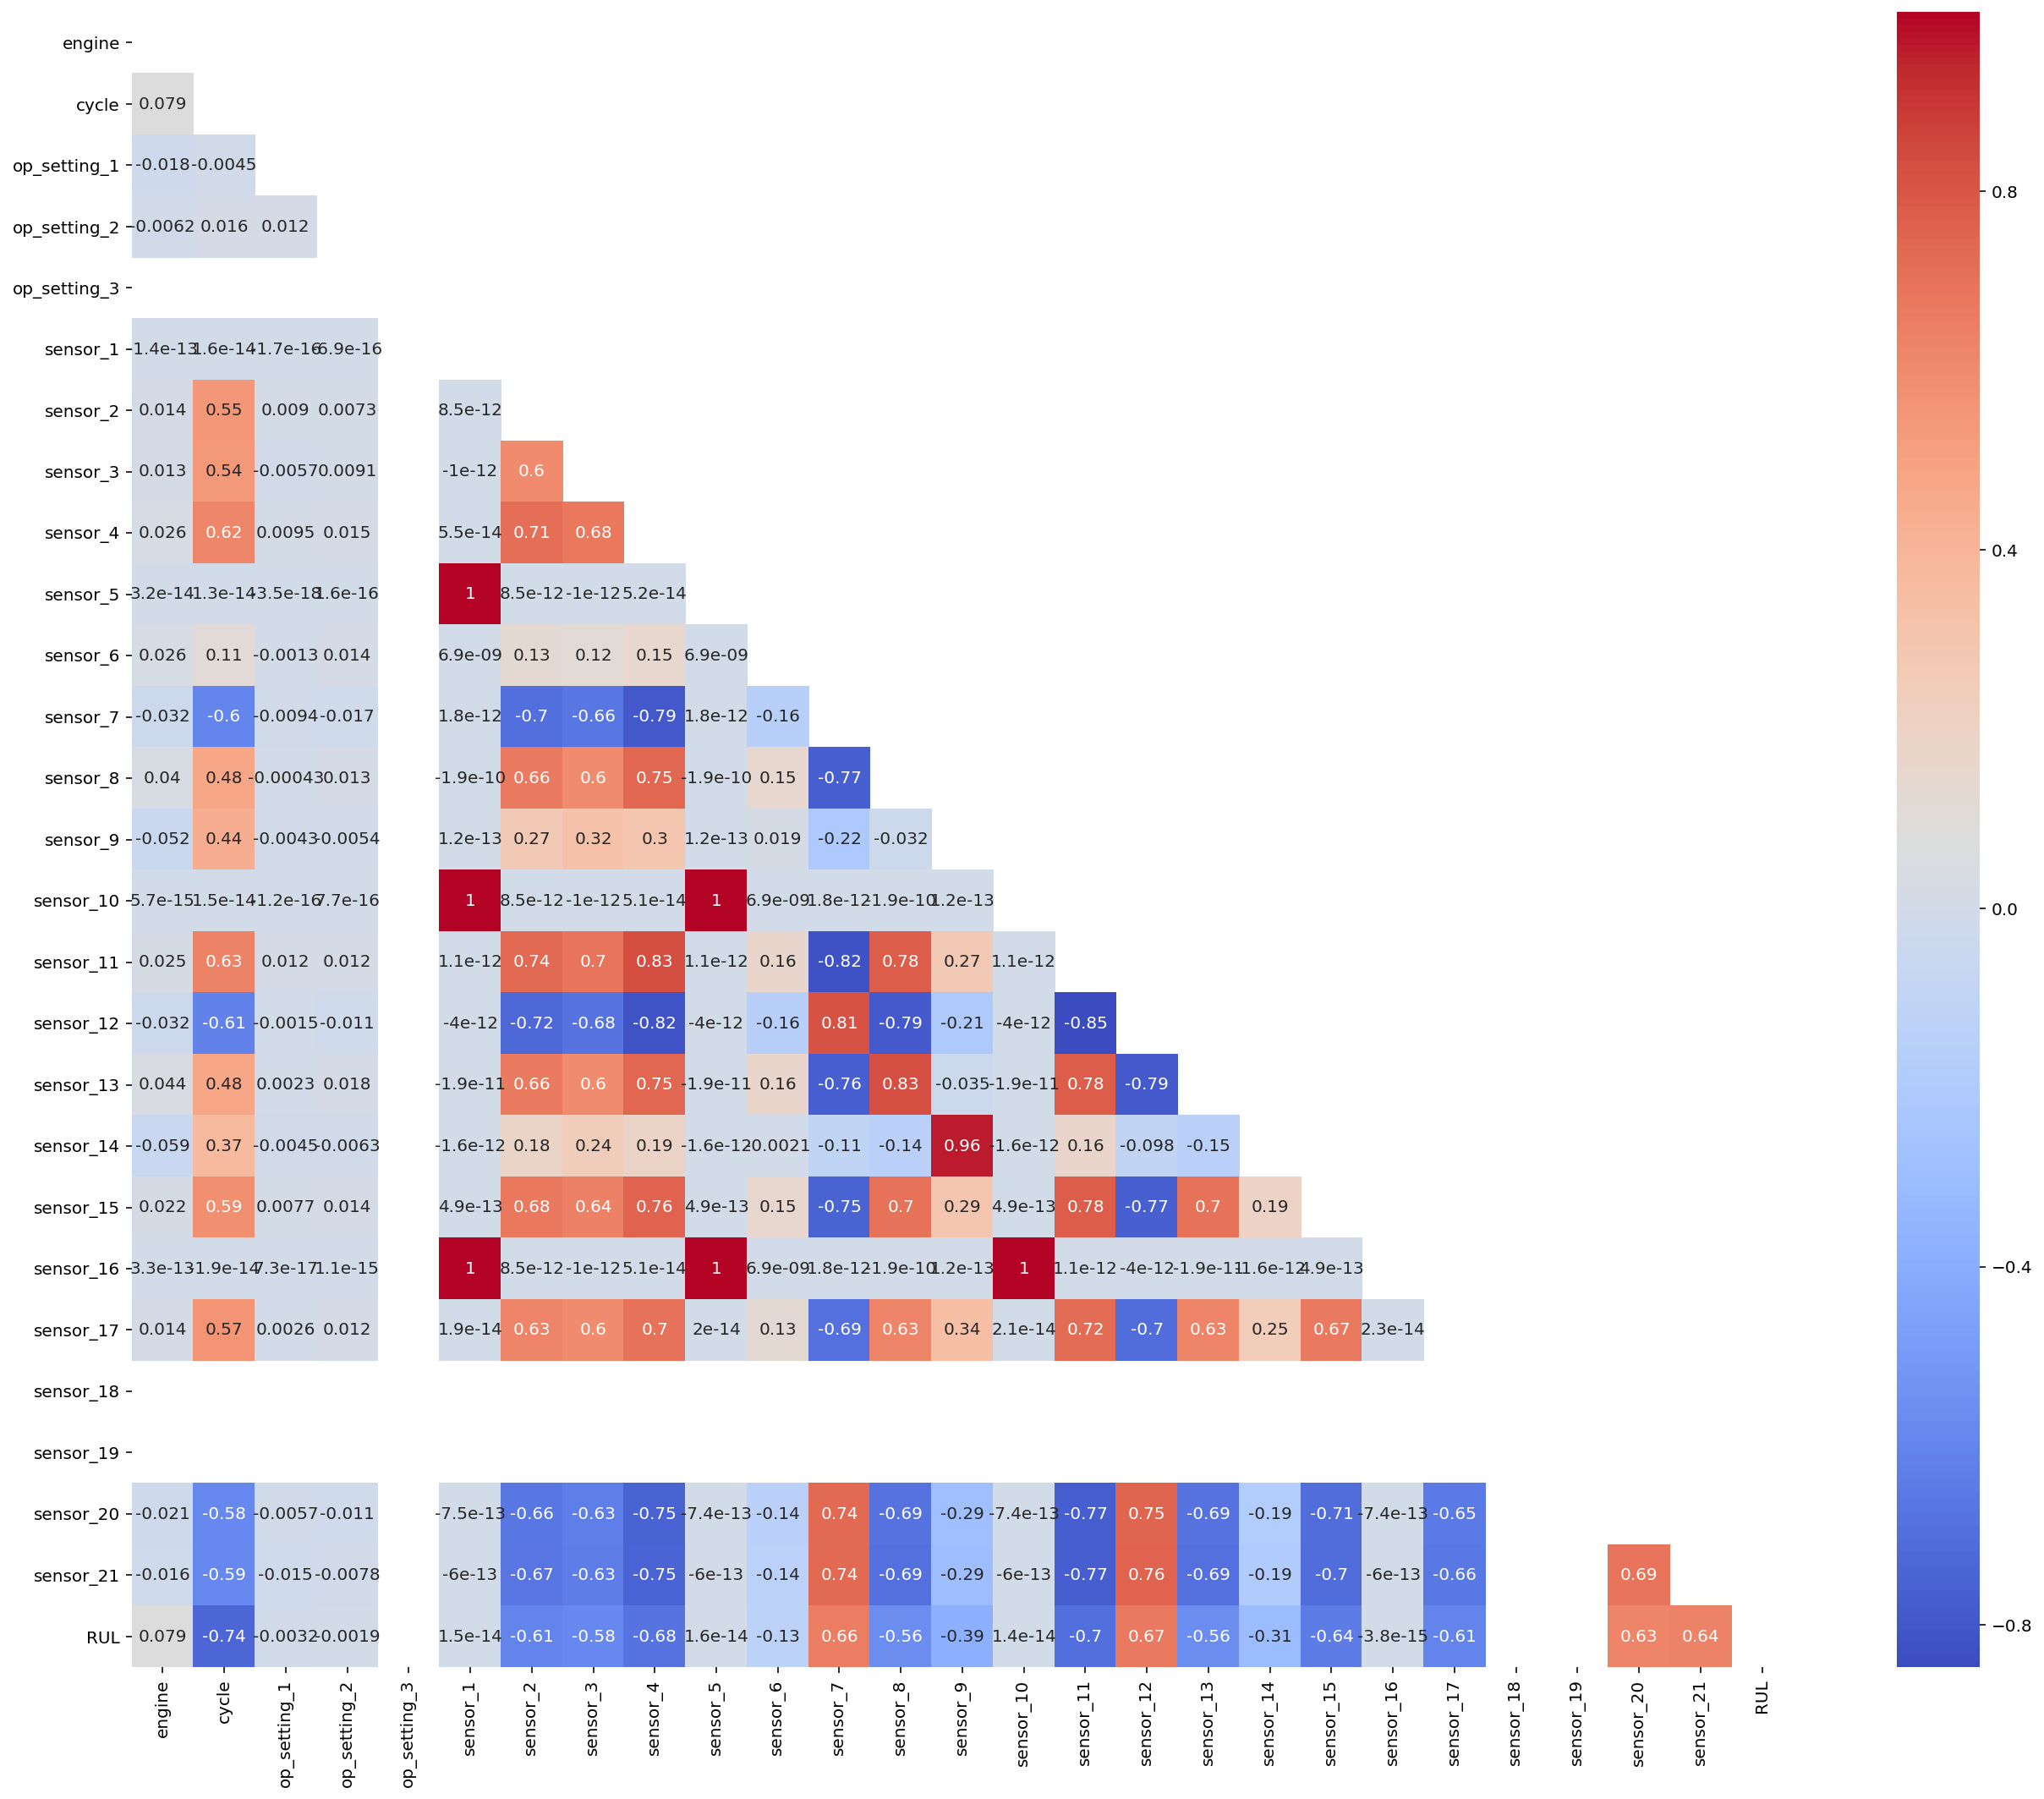

In [17]:
# Plot heatmap for df1_train dataset

heatmap(df1_train_ready)

In [18]:
# Create dataframe for single engine. Use engine number 1.

df_engine1=df1_train_ready[df1_train_ready['engine']==1]

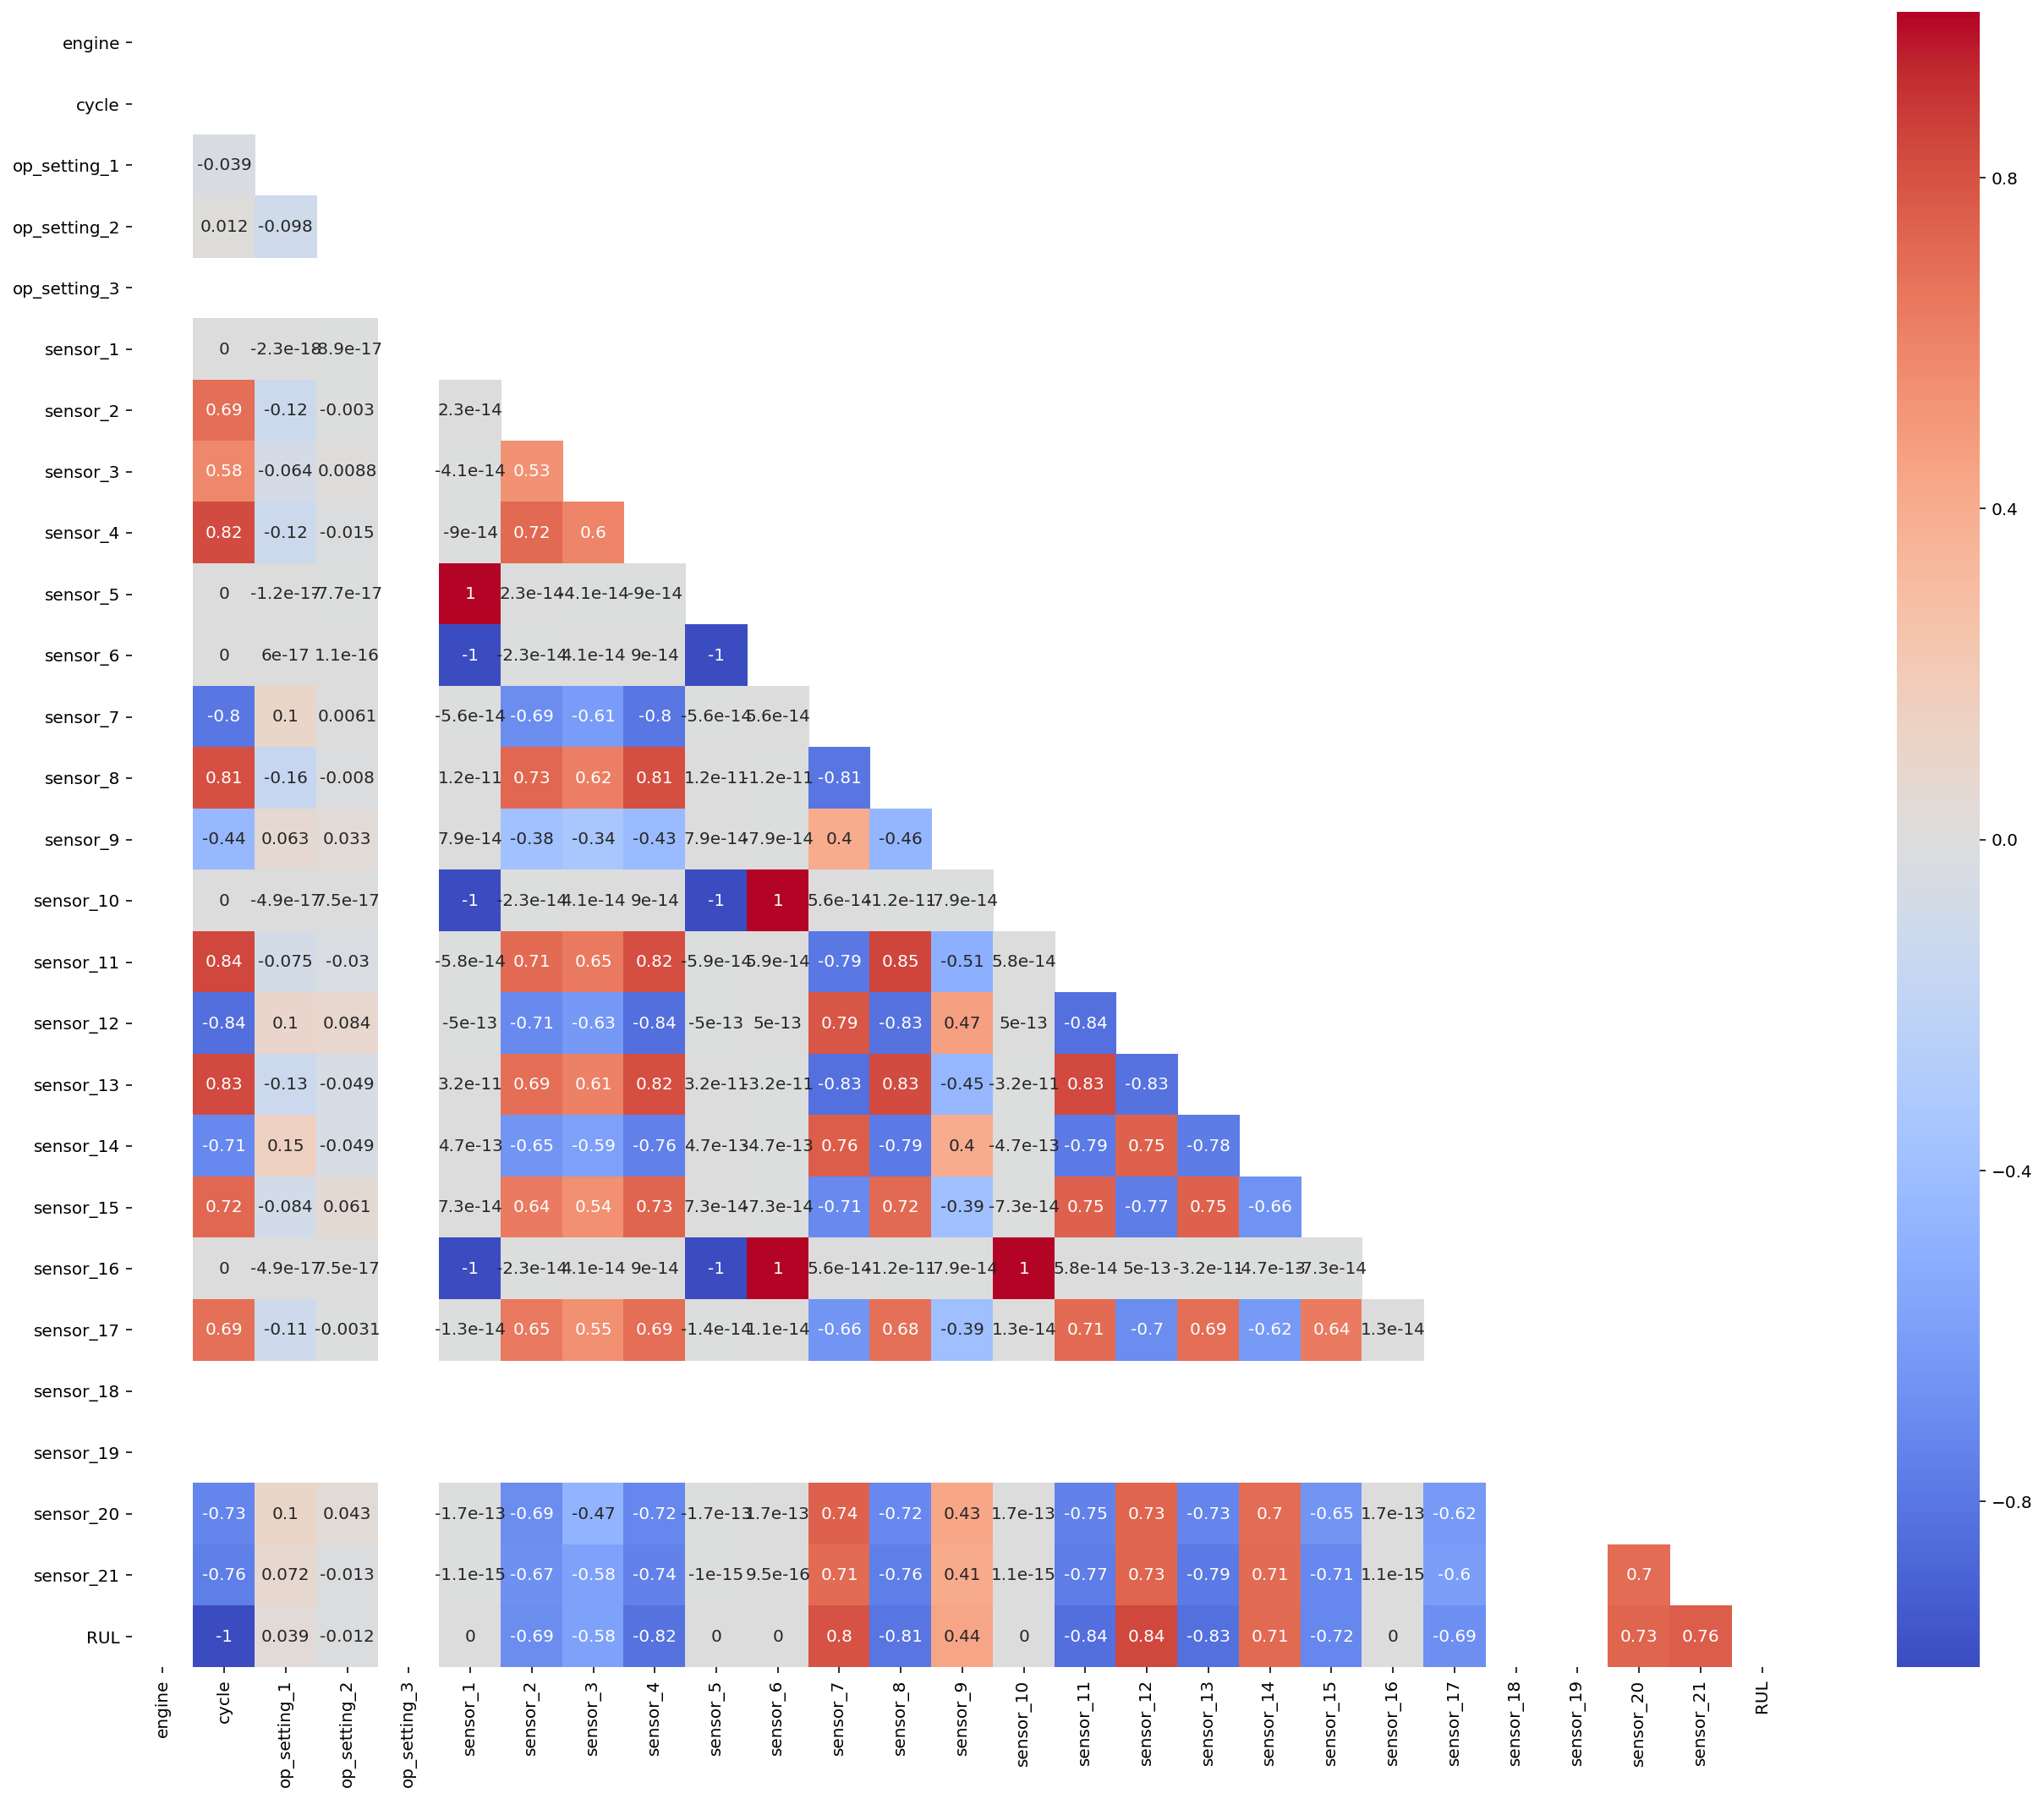

In [19]:
# Plot heatmap of single engine of the train data to see the correlation between features.

heatmap(df_engine1)

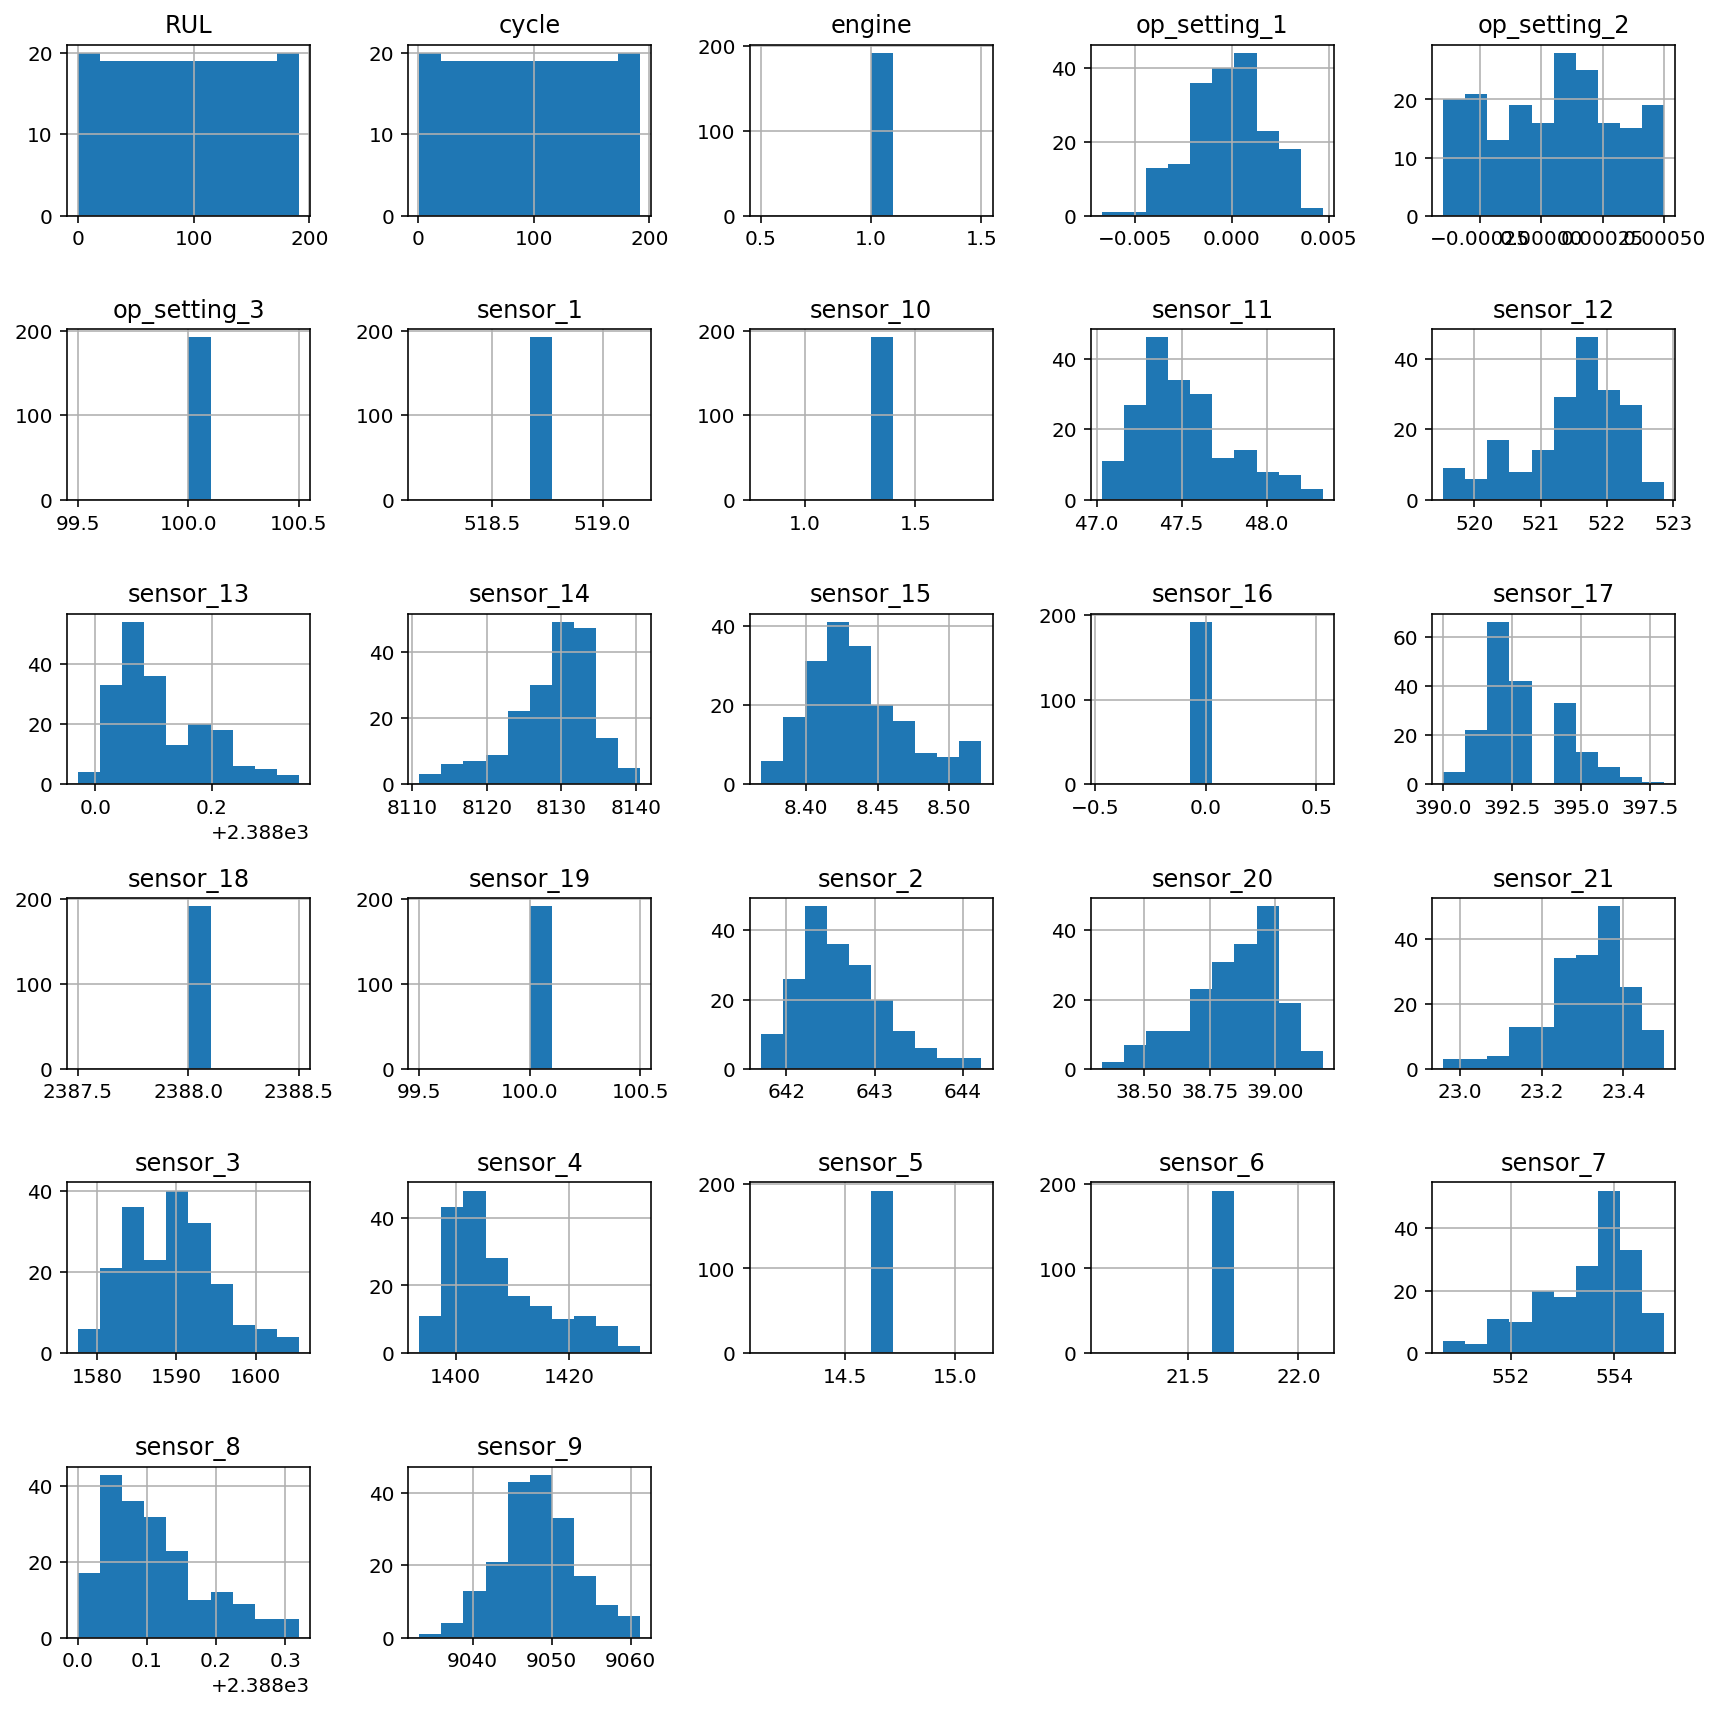

In [20]:
# Distribution plot for single engine

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df_engine1.hist(ax=ax)
plt.tight_layout()

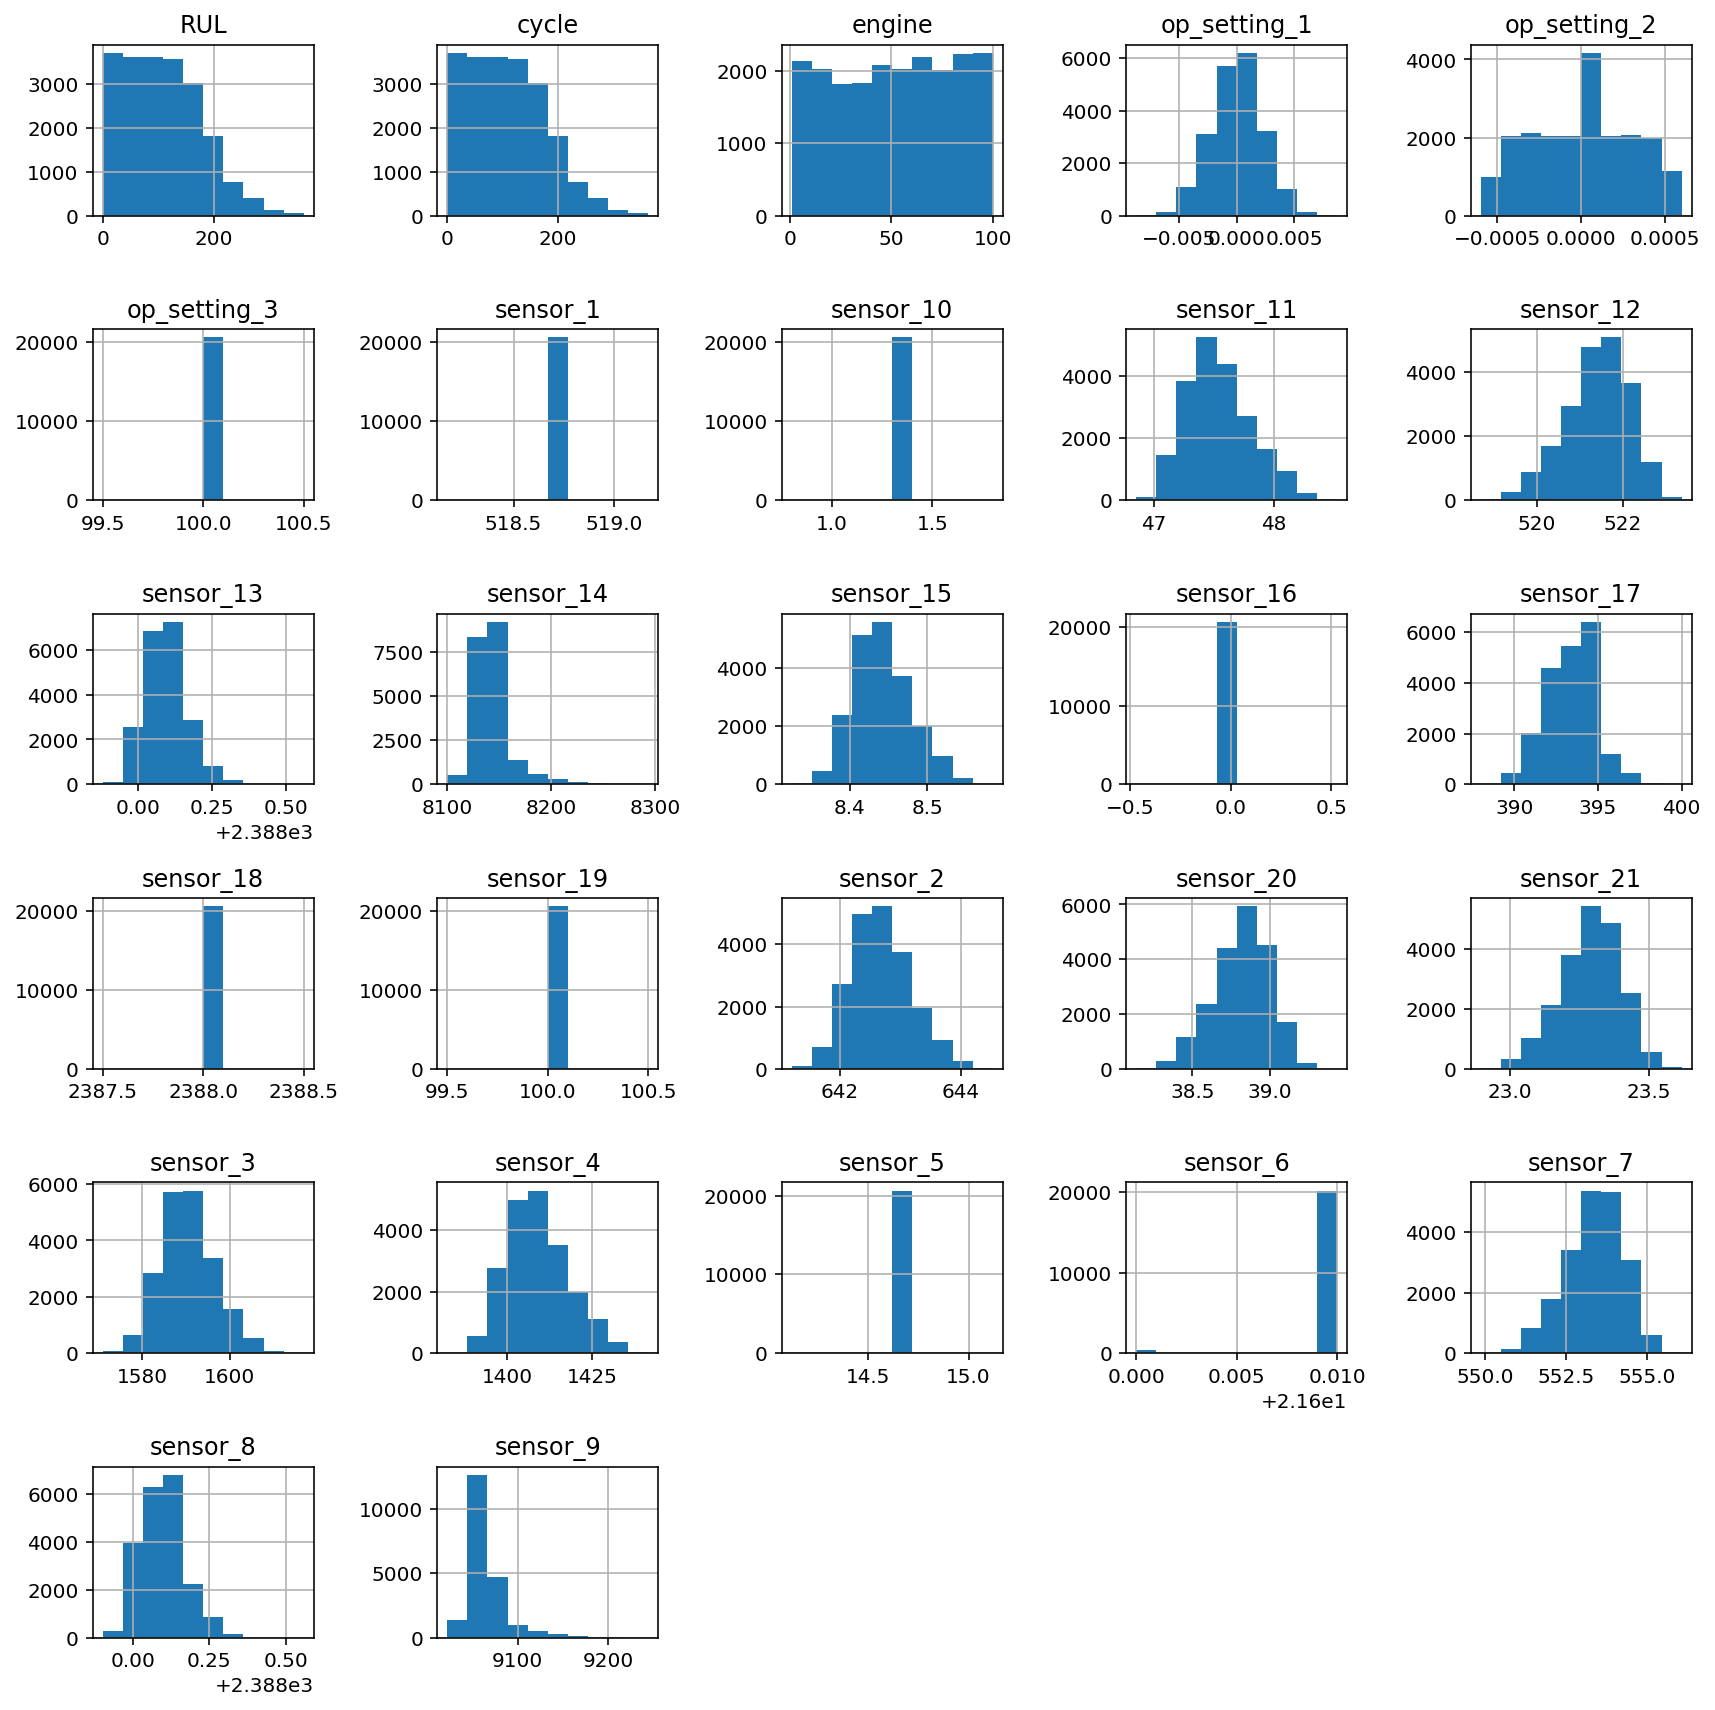

In [21]:
# Distribution plot for all engines

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df1_train_ready.hist(ax=ax)
plt.tight_layout()

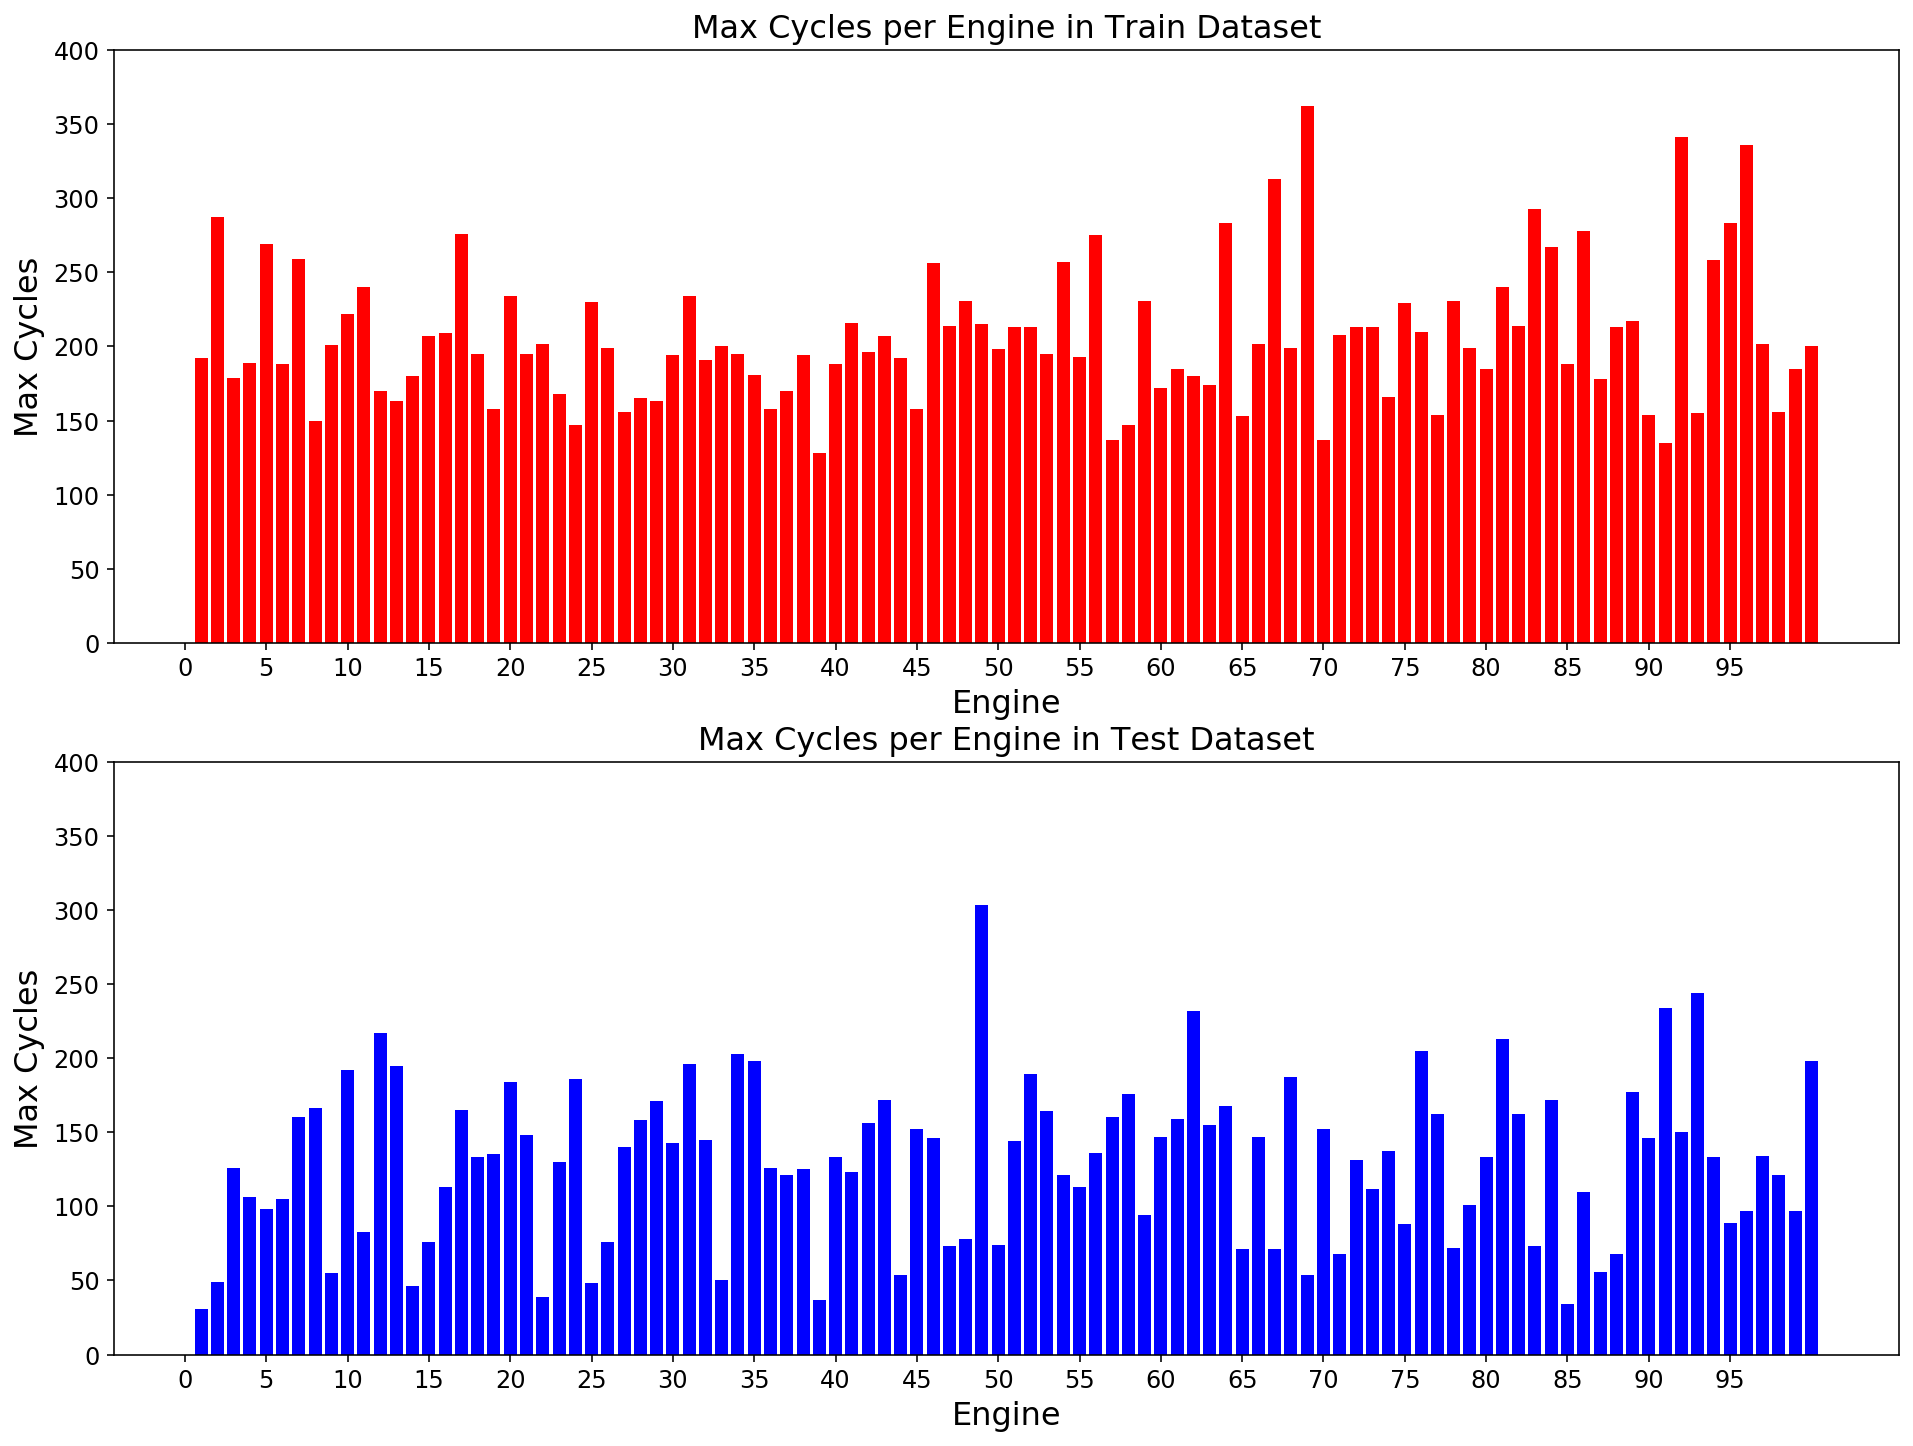

In [22]:
# Plot the maximium number of cycles per unit in the train and test datasets

cycle_train = df1_train.groupby('engine', as_index=False)['cycle'].max()
cycle_test = df1_test.groupby('engine', as_index=False)['cycle'].max()

fig = plt.figure(figsize = (16,12))
fig.add_subplot(2, 1, 1)
bar_labels = list(cycle_train['engine'])
bars = plt.bar(list(cycle_train['engine']), cycle_train['cycle'], color='red')
plt.ylim([0, 400])
plt.xlabel('Engine', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per Engine in Train Dataset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)

fig.add_subplot(2, 1, 2)
bars = plt.bar(list(cycle_test['engine']), cycle_test['cycle'], color='blue')
plt.ylim([0, 400])
plt.xlabel('Engine', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per Engine in Test Dataset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12);

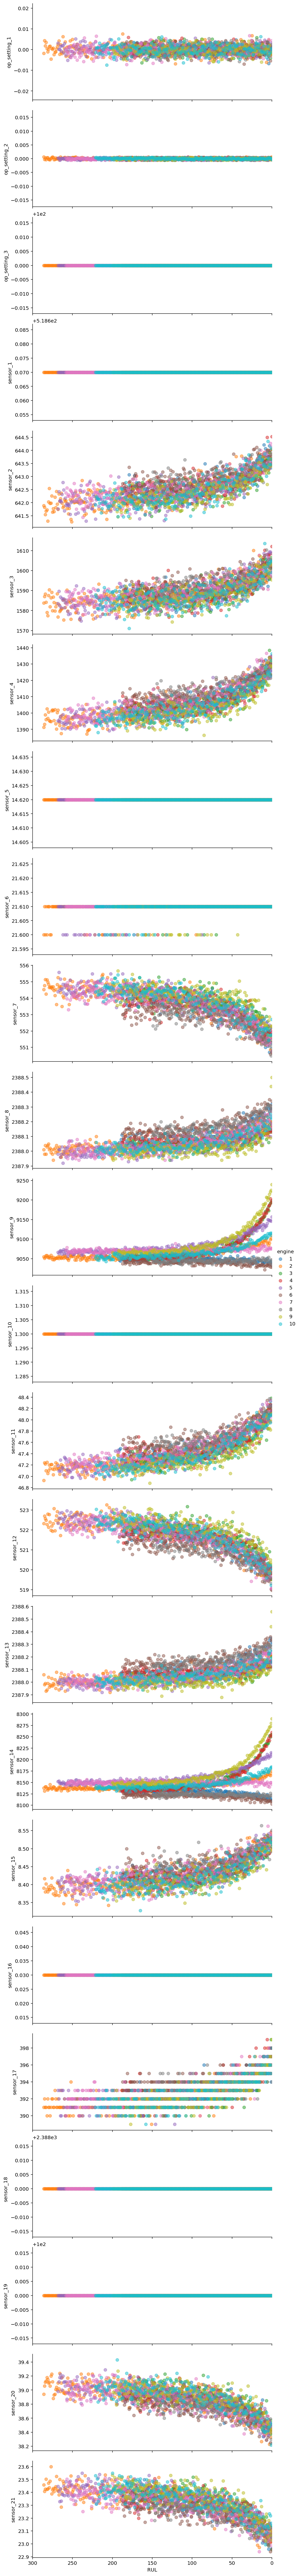

In [23]:
# Plot the senors and op_settings for 10 engines to see the trend against the RUL

headers=['op_setting_1','op_setting_2','op_setting_3','sensor_1','sensor_2',
         'sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9',
         'sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16',
         'sensor_17','sensor_18','sensor_19','sensor_20','sensor_21']

eng = df1_train_ready[df1_train_ready['engine']<11]

g = sns.PairGrid(data=eng, x_vars='RUL', y_vars= headers, hue='engine',size=3, aspect=2.5)
g = g.map(plt.scatter, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

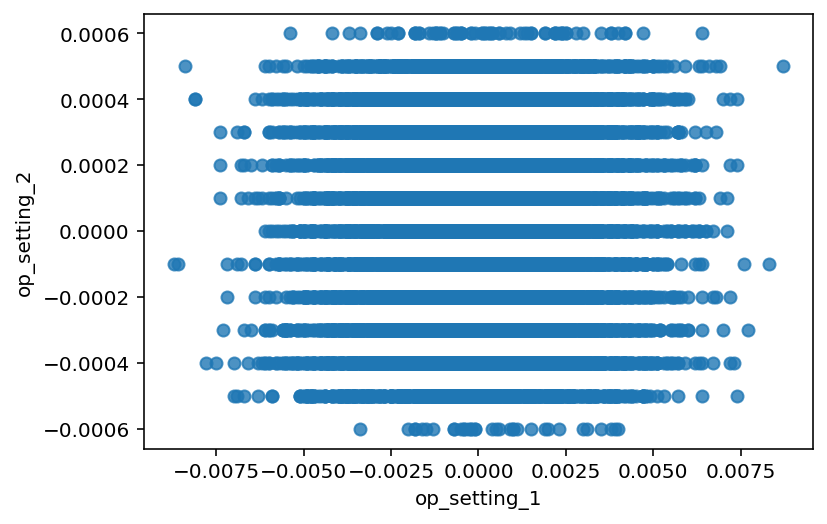

In [24]:
# From the distribtion plots, check op_setting 1 and 2 against the sensors 
# with corresponding narrow operating range

g = sns.regplot(data=df1_train_ready, x="op_setting_1", y="op_setting_2", fit_reg=False)

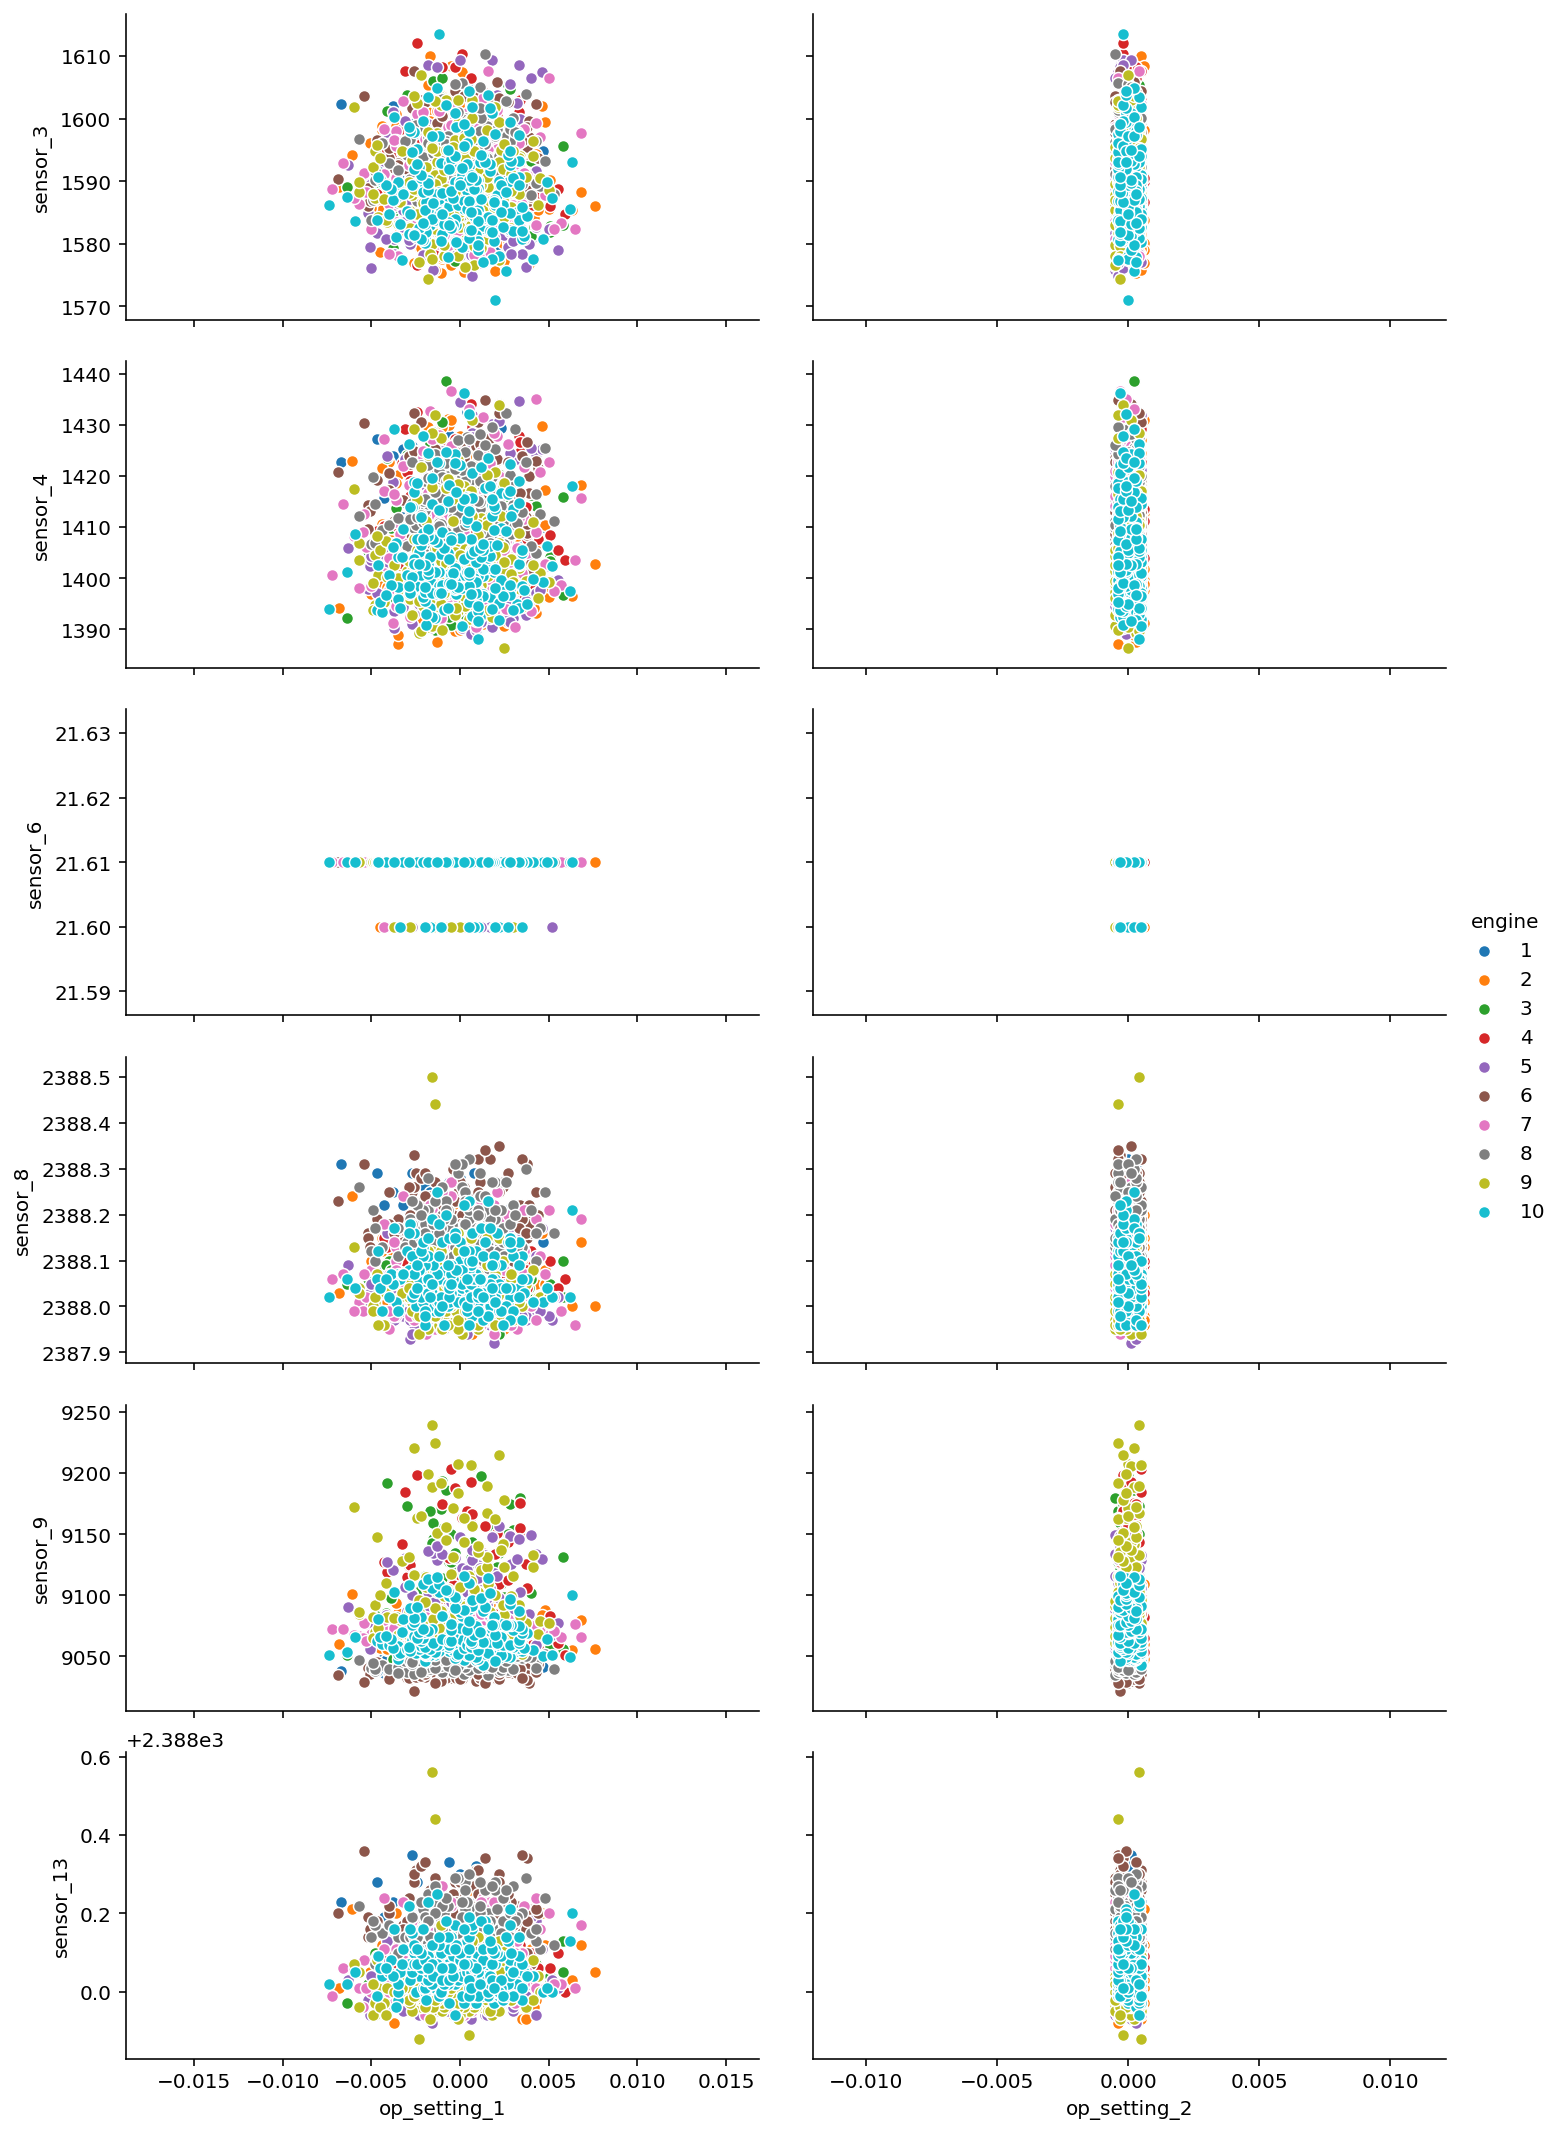

In [25]:
g = sns.pairplot(data=eng, x_vars=['op_setting_1', 'op_setting_2'],
                 y_vars=['sensor_3', 'sensor_4', 'sensor_6', 'sensor_8','sensor_9', 
                         'sensor_13'],
                 hue = 'engine', aspect = 2)


## Analysis from Heatmaps and Distribution Plots

From the train datasets distribution plots and heatmaps, it was observed that there are some features that do not have correlation at all eg, sensor_18, sensor_19 and op_setting_3.

The op_settings in the train dataset do not have significant correlation with the sensors. 

Some of the sensors show a negative trend while some show a positive trend, with the tail ends moving either upwards or downwards.

Some of the sensors data are constant and do not change with cycle time. These sensors can be considered for removal during modelling : opsetting_2, op_setting_3, sensor_1,sensor_5, sensor_6, sensor_10, sensor_16, sensor_18 and sensor_19. 



# Preprocessing and Modelling

### Scale the op_settings and sensors before commencing modelling

From the EDA, it can be seen that the sensor data varies over a wide range from min 0.02 to max 8243.  The dataset should thus be normalized using StandardScaler.

In [26]:
# Prepare the train and test data for modelling

X_train = df1_train_ready.drop(columns=['RUL'])
y_train = df1_train_ready[['RUL']]
X_test = df1_test
y_test = true_rul1['RUL']

In [27]:
# Scale the op_settings and sensors

ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [28]:
# keep back the engine and cycle values ie don't scale them

headers=['engine','cycle','op_setting_1','op_setting_2','op_setting_3','sensor_1',
         'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7',
         'sensor_8','sensor_9','sensor_10','sensor_11','sensor_12','sensor_13',
         'sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19',
         'sensor_20','sensor_21']

X_train_ready = pd.DataFrame(X_train_scaled)
X_train_ready.columns = headers
X_train_ready['engine'] = df1_train_ready['engine']
X_train_ready['cycle'] = df1_train_ready['cycle']

X_test_ready = pd.DataFrame(X_test_scaled)
X_test_ready.columns = headers
X_test_ready['engine'] = df1_test['engine']
X_test_ready['cycle'] = df1_test['cycle']

In [29]:
# Select the last entry for each engine in the test dataset 
# which is the last cycle before engine failure 
# Create a new test dataset with the same shape as the true RUL dataset ie 100 engines
# The new test dataset will be X and the true RUL will be y

df_test_pred = pd.DataFrame(columns=headers)
n = 0
for i in range(0,len(X_test_ready)):
    if (X_test_ready['engine'].values[i] !=n):
        df_test_pred = df_test_pred.append(X_test_ready.iloc[i-1])
        n+=1

In [30]:
# Sort the test dataset according to engine number

X_test_pred = df_test_pred.sort_values('engine', axis=0, ascending=True).reset_index(drop=True)

In [31]:
# Confirm that X_test_pred has the same number of rows as the true_RUL

X_test_pred.shape

(100, 26)

### Create Baseline Regresson Model

For the regression problem ie predicting the RUL, linear, Ridge and Lasso regression models are used to baseline the scores described below, without removing any features or conducting feature engineering.  

### Aggregated Score for RUL Prediction

2 main scoring metrics are used : Root Square Mean Error (RSME) and the NASA aggregate score.

The R2 score is also calculated to provide an indication on the goodness of the fitting but is not the main metrics in this project. 

The RMSE gives equal penalty to early and late predictions.  

The NASA aggregate score is a weighted sum of RUL errors. The scoring function is an asymmetric function that penalizes late predictions more than the early predictions as late predictions could cause serious system failures in real-life applications as the maintenance procedure will be scheduled too late.  The scoring function is expressed by the equation below.  UUT refers to the engine in this project. 

As a reference, the NASA top 20 aggregate scores range from 436.84 to 2430.42 for a unseen test set of 435 engines. Models with aggregate scores above 20000 are considered weak predictors (reference : Data analysis and processing techniques for remaining useful life
estimations, John Scott Bucknam, Rowan University).

Nevertheless, the main objective is to achieve the smallest value possible for both the NASA aggregate score and RMSE.

<img src="images/scoring%20metrics.png" width="350"/>


Linear, Ridge and Lasso regressions were used and compared. Lasso Regression was found to have the best aggregate and RMSE scores among the 3 models and will be used as baseline.


|Model|R2 Score|RMSE Score |Aggregate Score|
|---|---|---|---|
|Baseline Linear Regression|0.368|32.865|21588.316|
|Baseline Ridge|0.375|32.865|22278.879|
|Baseline Lasso|0.443|31.006|21193.826|

In [32]:
# Function to predict the RUL and return the results

def predict(model, test_data, true_RUL):

    # predict the RUL
    prediction = model.predict(test_data).astype(int)
    
    # Append the true RUL column to the predicted RUL column
    result = pd.DataFrame(prediction).join(true_RUL)
    result.rename(columns={0 : 'pred_RUL'}, inplace=True)
    return result

In [33]:
# Function to compute the NASA aggregate score

def agg_score(x):
    d = x.pred_RUL-x.RUL
    s = (np.exp(-d/10))-1 if d < 0. else (np.exp(d/13))-1
    return s

In [34]:
# Function to calculate the all the scores

models = [] 
nasa_scores=[]
rmse_scores = []
r2_scores = []

def score(pred, model):
    
    pred["score"]=pred.apply(agg_score, axis=1)

    rmse_test = np.sqrt(mean_squared_error(pred.RUL, pred.pred_RUL))
    
    r2_lr = r2_score(pred.RUL, pred.pred_RUL)
      
    
    # append the scores and model into a dataframe for easy reference later   
    models.append(model)
    nasa_scores.append(round(sum(pred.score),3))
    rmse_scores.append(round(rmse_test,3))
    r2_scores.append(round(r2_lr,3))
    score_summary = pd.DataFrame({'Model': models, 'NASA Score': nasa_scores, 
                                  'RMSE Score': rmse_scores,
                                  'R2 Score': r2_scores}).sort_values(by = 'NASA Score',ignore_index=True)
    return score_summary.sort_values(by = ['NASA Score'], ignore_index=True)

In [35]:
# Instantiate Linear Regression, Ridge and Lasso

lr = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(0, 5, 200))
lasso = LassoCV(n_alphas=500)

In [36]:
### Evaluate the 3 models

lr_scores = cross_val_score(lr, X_train_ready, y_train, cv=10)
ridge_scores = cross_val_score(ridge, X_train_ready, y_train, cv=10)
lasso_scores = cross_val_score(lasso, X_train_ready, y_train, cv=10)

print( 'LR score    : ' , lr_scores.mean())
print( 'Ridge score : ' , ridge_scores.mean())
print( 'Lasso score : ' , lasso_scores.mean())

LR score    :  0.6700019236421867
Ridge score :  0.6701889533401767
Lasso score :  0.6624476757409543


In [37]:
# Fit the 3 models

model_lr = lr.fit(X_train_ready, y_train)
model_ridge = ridge.fit(X_train_ready, y_train)
model_lasso = lasso.fit(X_train_ready, y_train)

In [38]:
# Score the 3 models

score_lr = lr.score(X_train_ready, y_train)
score_ridge = ridge.score(X_train_ready, y_train)
score_lasso = lasso.score(X_train_ready, y_train)
print ('R2 Score of LR model    : ', score_lr)
print ('R2 Score of Ridge model : ', score_ridge)
print ('R2 Score of Lasso model : ', score_lasso)

R2 Score of LR model    :  0.6698572018608682
R2 Score of Ridge model :  0.6698256845015992
R2 Score of Lasso model :  0.6599166928945399


In [39]:
# Calculate the RMSE score

rmse_train = np.sqrt(mean_squared_error(y_train, lr.predict(X_train_ready)))
print('RMSE Train Score of LR Model : ', rmse_train)

RMSE Train Score of LR Model :  39.57671741181993


In [40]:
# Get the prediction results using the predict function

pred_lr = predict(model_lr, X_test_pred,true_rul1)
pred_ridge = predict(model_ridge, X_test_pred,true_rul1)
pred_lasso = predict(model_lasso, X_test_pred,true_rul1)

In [41]:
# Inspect the prediction dataframe

pred_lr.head()

pred_RUL  RUL
0       145  112
1       106   98
2        44   69
3        65   82
4        78   91

In [42]:
# Compute the scores

score(pred_lr, "Baseline LR")
print('')
score(pred_ridge, "Baseline Ridge")
print('')
score(pred_lasso, "Baseline Lasso")

Model  NASA Score  RMSE Score  R2 Score
0  Baseline Lasso   21193.826      31.006     0.443
1     Baseline LR   21588.316      33.031     0.368
2  Baseline Ridge   22278.879      32.865     0.375

In [43]:
# Create plot function to plot the predicted RUL vs true RUL

def plot(results, model):
    plt.figure(figsize=(10,6))
    plt.plot([results.RUL.min(), results.RUL.max()], [results.RUL.min(), results.RUL.max()],color = 'red', linewidth = 2, label ='Zero Error Line')
    plt.scatter(results.RUL, results.pred_RUL)
    plt.title('{} :  Predicted RUL vs True RUL'.format(model))
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.legend()
    return

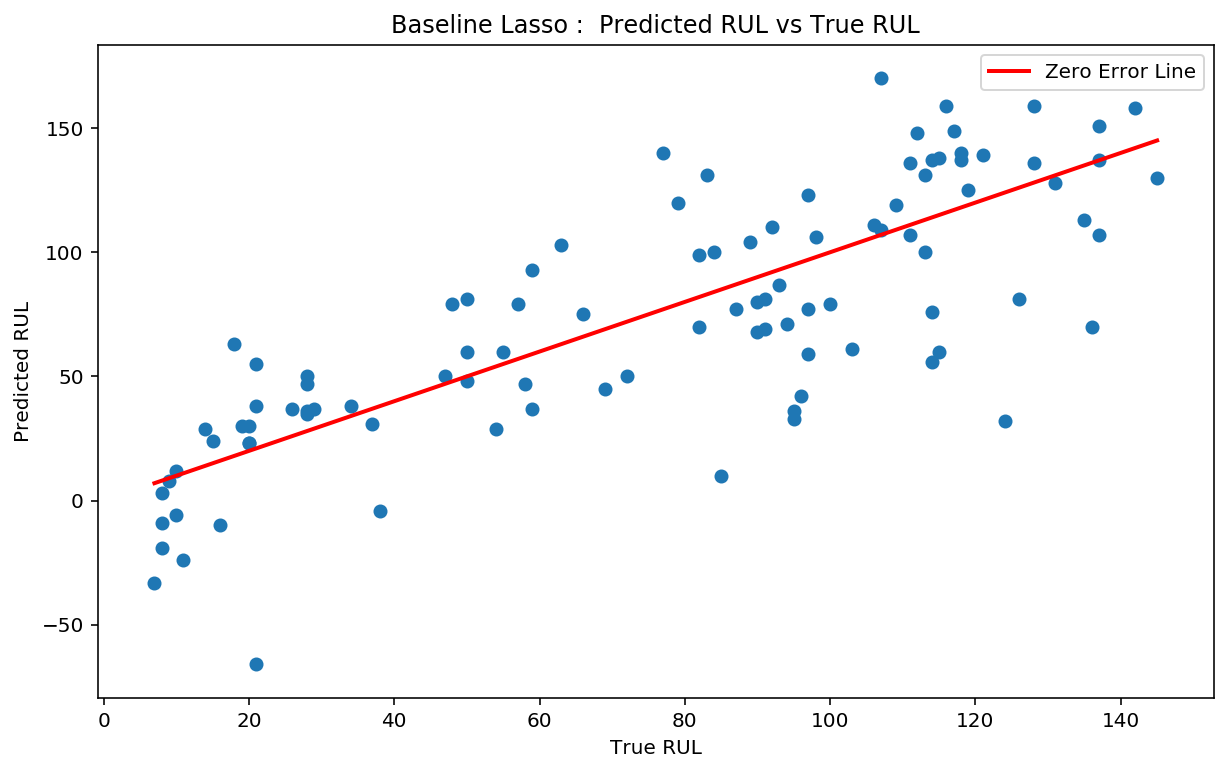

In [44]:
# Plot the predicted RUL vs true RUL for the Lasso LR

plot(pred_lasso,'Baseline Lasso')

### Remove features that don't change with the cycle.

From the EDA and distribution graphs, op_setting_3, sensor_1,sensor_5, sensor_10, sensor_16, sensor_18 and sensor_19 can be removed. 

### Transform the features with PolynomialFeatures

In [45]:
# Drop the unwanted features in the train dataset

col = ['op_setting_3', 'sensor_1', 'sensor_5', 
       'sensor_10', 'sensor_16', 'sensor_18','sensor_19']

X_train_poly_ready = X_train_ready.drop(columns=col, axis=1)
X_test_poly_ready = X_test_pred.drop(columns=col, axis = 1)

In [46]:
X_test_poly_ready.head()

engine  cycle  op_setting_1  op_setting_2  sensor_2  sensor_3  sensor_4  \
0     1.0   31.0     -0.267330      1.346041  0.261702 -1.374993 -0.871010   
1     2.0   49.0      0.822291     -0.354527  0.186867 -0.301655  0.911272   
2     3.0  126.0     -0.721339      1.346041  1.010048  0.329956  2.116406   
3     4.0  106.0      0.549886      1.346041  0.760599  1.285367  0.320667   
4     5.0   98.0     -0.585136     -1.374869 -0.511589  0.367932  2.186681   

   sensor_6  sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  \
0   0.17566  0.972429  0.157306 -0.175533  -0.950459   0.075547  -0.193647   
1   0.17566 -0.348652  0.505498 -1.192513   1.295473  -0.013802   0.333296   
2   0.17566 -1.713770  1.550073 -0.799887   2.367395  -1.639948   1.211535   
3   0.17566 -1.640376  1.027786 -0.621500   1.193385   0.236374   0.684592   
4   0.17566 -0.686262  0.505498 -0.386274   0.223551  -1.336162   1.387182   

   sensor_14  sensor_15  sensor_17  sensor_20  sensor_21  
0  -0.867455  -0.808184   0.347276  -0.582328   0.231312  
1  -1.182525   0.849967  -1.274088  -0.582328  -0.879045  
2  -0.734949  -0.480690   1.968639   0.264679  -0.734009  
3  -0.520976   1.294669   1.968639  -2.205758  -0.923031  
4  -1.296382   0.357003   1.157958  -1.005832   0.902995

In [47]:
# Instantiate and transform the features to higher degree features

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_poly_ready)
X_test_poly = poly.fit_transform(X_test_poly_ready)

In [48]:
# Fit the transformed features to Linear Regression model

model_poly = LinearRegression()
model_poly = model_poly.fit(X_train_poly, y_train)

In [49]:
# Score on the train dataset

lr_poly_scores = model_poly.score(X_train_poly, y_train)
print ('R2 Train Score for PolyFeatures LR : ', lr_poly_scores)

R2 Train Score for PolyFeatures LR :  0.7349750011450344


In [50]:
# Predict on the test dataset

pred_poly = model_poly.predict(X_test_poly).astype(int)

In [51]:
# Transform the prediction to dataframe for scoring

test_result = X_test_poly_ready.copy()
test_result['RUL'] = pd.DataFrame(pred_poly)
test_rul = test_result.groupby('engine', as_index=False)['RUL'].min()
test_rul.rename(columns={'RUL' : 'pred_RUL'}, inplace=True)
result_poly = test_rul.join(true_rul1)

In [52]:
# Score the model

score(result_poly, 'PolyFeatures LR')

Model  NASA Score  RMSE Score  R2 Score
0  PolyFeatures LR   12868.321      32.729     0.380
1   Baseline Lasso   21193.826      31.006     0.443
2      Baseline LR   21588.316      33.031     0.368
3   Baseline Ridge   22278.879      32.865     0.375

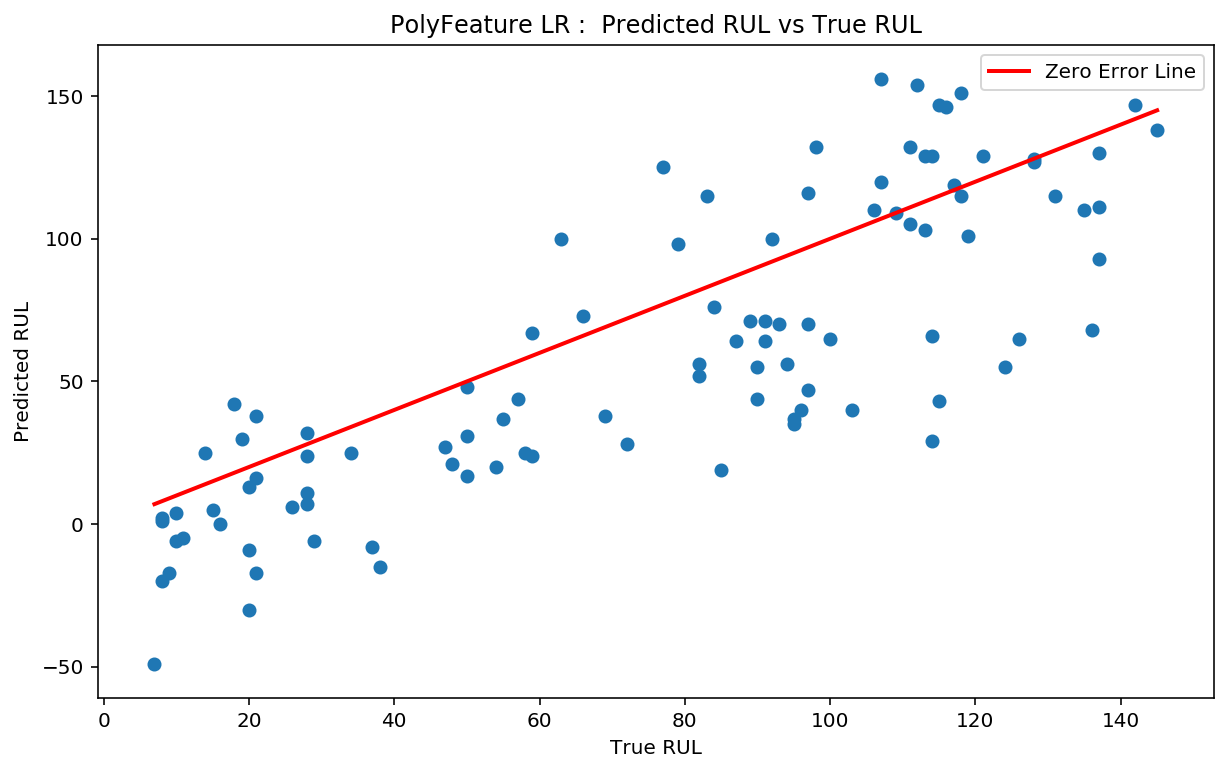

In [53]:
# Plot the predicted RUL vs true RUL for the PolyFeatures LR

plot(result_poly,'PolyFeature LR')

### Try Random Forest Regressor to improve the scores

In [54]:
# Use GridSearchCV to find the best parameters for Random Forrest Regressor
# Note : the parameters are used based on previously run searches to reduce computation time

rf = RandomForestRegressor(random_state = 42)

# Create the parameter grid for RFR
param_grid_rf = {
    'bootstrap': [True, False],
    'max_depth': [int(x) for x in np.linspace(2, 20, 1)],
    'max_features': [int(x) for x in np.linspace(1, 20, 1)],
    'n_estimators': [200, 300, 400, 500]
}
# Instantiate model
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
                          cv = 5, n_jobs = -1, verbose = 1)

In [55]:
# Fit the grid search to the train data

grid_rf.fit(X_train_ready, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [56]:
# Find the best parameters

grid_rf.best_params_

{'bootstrap': True, 'max_depth': 2, 'max_features': 1, 'n_estimators': 300}

In [57]:
# Find the best estimator
grid_rf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features=1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [58]:
best_grid_rf = grid_rf.best_estimator_

In [59]:
# Get the test score

print ('Train Score for RFR : ',best_grid_rf.score(X_train_ready,y_train) )

Train Score for RFR :  0.5094064561455063


In [60]:
# Predict the test dataset

pred_grid_rf = predict(best_grid_rf, X_test_pred, true_rul1)

In [61]:
# Score the RF model

score(pred_grid_rf, 'Random Forest Regressor')

Model  NASA Score  RMSE Score  R2 Score
0  Random Forest Regressor    1928.376      25.076     0.636
1          PolyFeatures LR   12868.321      32.729     0.380
2           Baseline Lasso   21193.826      31.006     0.443
3              Baseline LR   21588.316      33.031     0.368
4           Baseline Ridge   22278.879      32.865     0.375

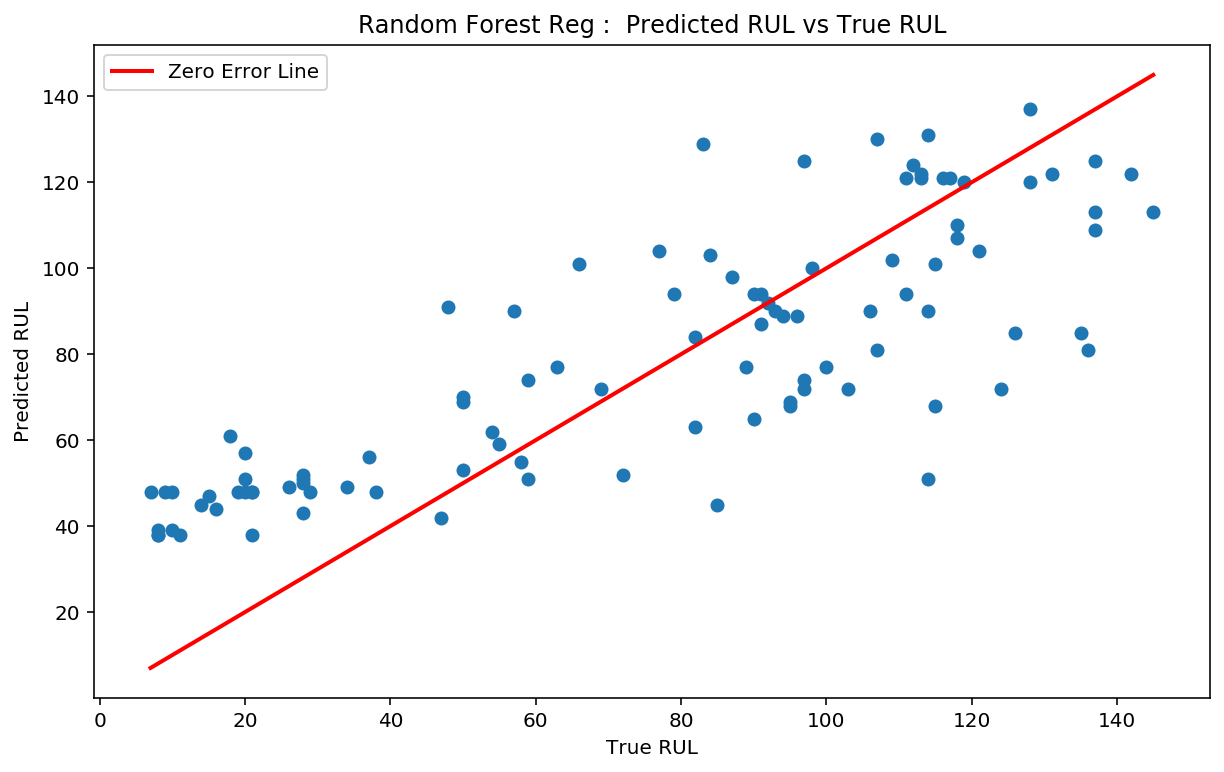

In [62]:
# Plot the predicted RUL vs true RUL for the RFR

plot(pred_grid_rf, 'Random Forest Reg')

In [63]:
# Find the feature importance using the best parameters

rf_feat = RandomForestRegressor(n_estimators = 300, max_features = 1,
                           max_depth = 2, random_state = 42)

rf_feat.fit(X_train_ready, y_train)

feat_impt = pd.Series(rf_feat.feature_importances_, index = X_train_ready.columns)

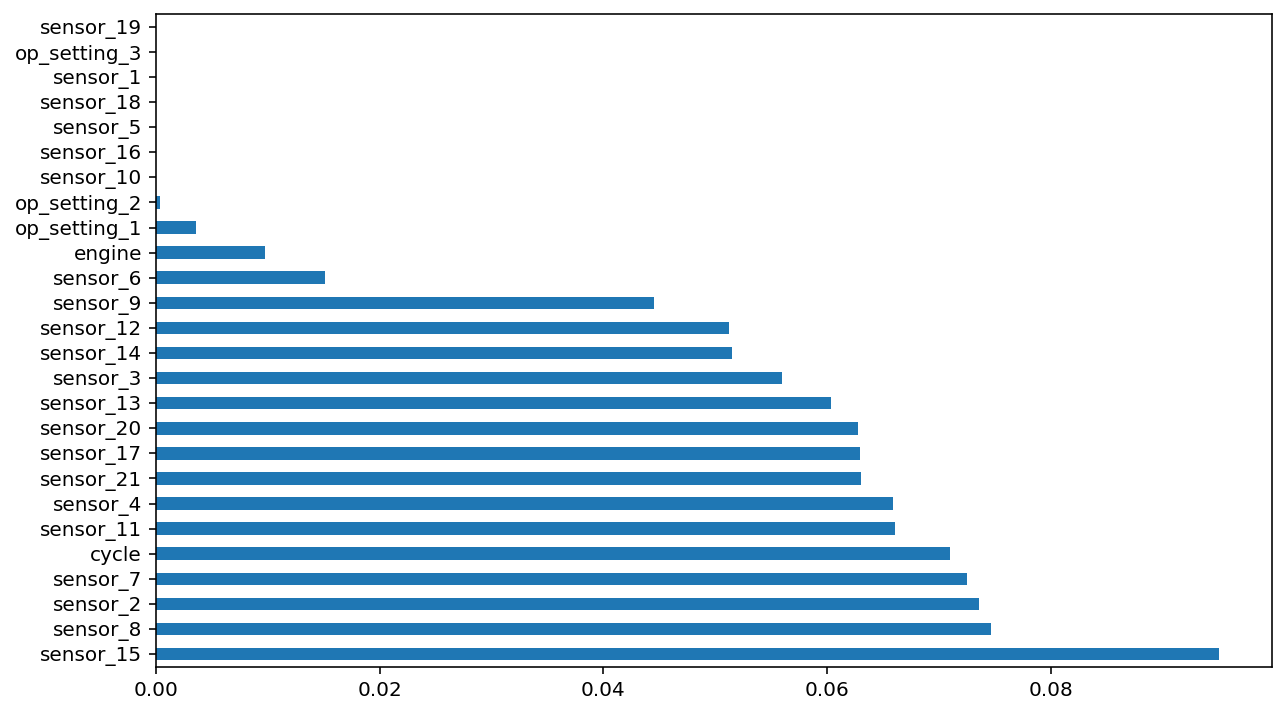

In [64]:
plt.figure(figsize = (10,6))
feat_impt.sort_values(ascending = False).plot(kind='barh');

### Apply Gradient Boosting (XGBoost) to improve scores

In [65]:
# Use GridSearchCV to find the best parameters for XGBoost
# ref : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Note : the parameters are input from an initial search which took over 30 mins

"""
xgboost = xgb.XGBRegressor(random_state = 42)
     
     parameters = {
     'max_depth'        : [2, 3, 4],
     'learning_rate'    : [0.01, 0.05, 0.1],
     'gamma'            : [0,1],
     'subsample'        : [0.5,1],
     'colsample_bytree' : [0.3, 0.5], 
     'n_estimators'     : [200, 300, 500]
     }

grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=parameters, n_jobs=-1, cv=5, verbose = 1)
"""

grid_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.01, gamma=0, subsample=1,
                           colsample_bytree=0.5, max_depth=2, random_state=42)

grid_xgb.fit(X_train_ready, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.5, gamma=0, learning_rate=0.01,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=1)

In [66]:
print ('Train Score for XGB : ',grid_xgb.score(X_train_ready,y_train) )

Train Score for XGB :  0.7145438672366853


In [67]:
# Predict the test dataset

pred_grid_xgb = predict(grid_xgb, X_test_pred, true_rul1)

In [68]:
# Score the model

score(pred_grid_xgb, 'XGBoost')

Model  NASA Score  RMSE Score  R2 Score
0  Random Forest Regressor    1928.376      25.076     0.636
1                  XGBoost   10713.416      28.638     0.525
2          PolyFeatures LR   12868.321      32.729     0.380
3           Baseline Lasso   21193.826      31.006     0.443
4              Baseline LR   21588.316      33.031     0.368
5           Baseline Ridge   22278.879      32.865     0.375

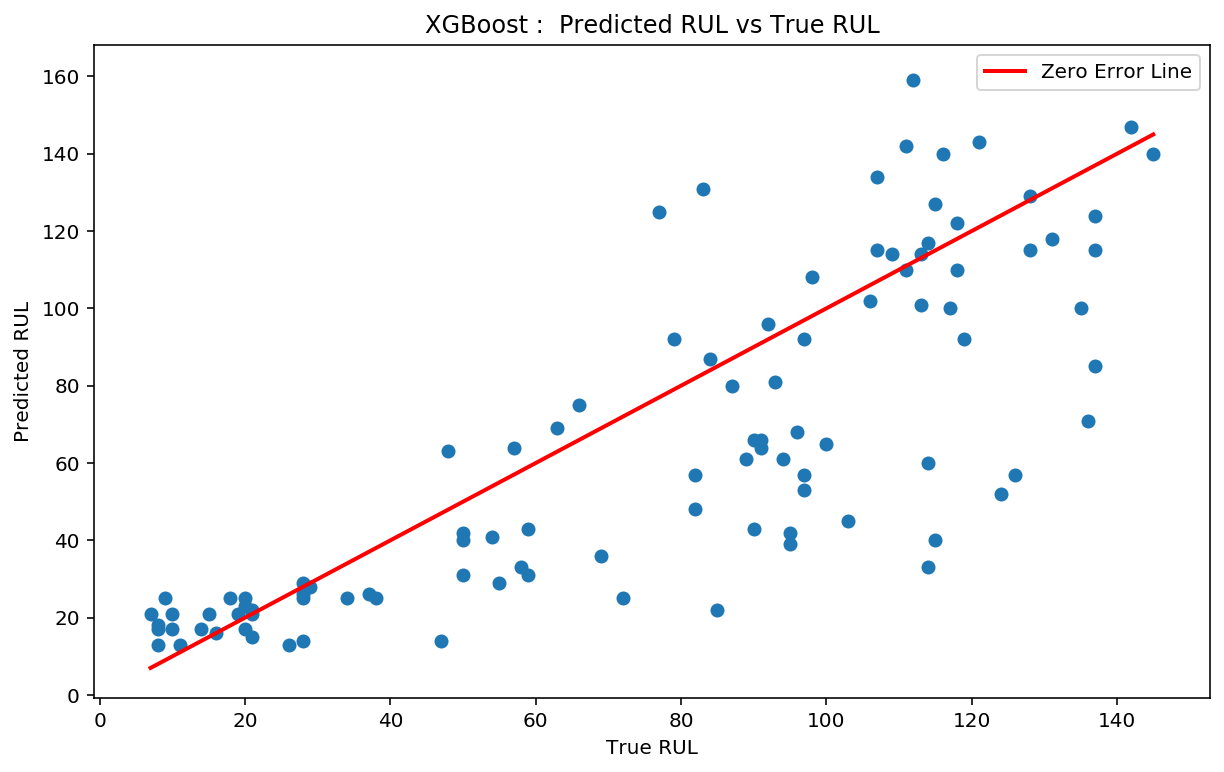

In [69]:
# Plot the predicted RUL vs true RUL for XGBoost

plot(pred_grid_xgb,'XGBoost')

### From the feature importance in RFR, remove those features that are not important and fit the XGBoost again to see if scores can be improved

In [70]:
# Remove op_setting 2 & 3, sensors 1, 5, 10, 16, 18 & 19

features = ['cycle','op_setting_1','sensor_2',
         'sensor_3','sensor_4','sensor_6','sensor_7','sensor_8','sensor_9',
         'sensor_11','sensor_12','sensor_13','sensor_14','sensor_15',
         'sensor_17','sensor_20','sensor_21']

In [71]:
X_train_ready2 = X_train_ready[features]
X_test_pred2 = X_test_pred[features]

In [72]:
X_train_ready2.head()

cycle  op_setting_1  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  \
0      1     -0.315980 -1.721725 -0.134255 -0.925936  0.141683  1.121141   
1      2      0.872722 -1.061780  0.211528 -0.643726  0.141683  0.431930   
2      3     -1.961874 -0.661813 -0.413166 -0.525953  0.141683  1.008155   
3      4      0.324090 -0.661813 -1.261314 -0.784831  0.141683  1.222827   
4      5     -0.864611 -0.621816 -1.251528 -0.301518  0.141683  0.714393   

   sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  \
0 -0.516338 -0.862813  -0.266467   0.334262  -1.058890  -0.269071  -0.603816   
1 -0.798093 -0.958818  -0.191583   1.174899  -0.363646  -0.642845  -0.275852   
2 -0.234584 -0.557139  -1.015303   1.364721  -0.919841  -0.551629  -0.649144   
3  0.188048 -0.713826  -1.539489   1.961302  -0.224597  -0.520176  -1.971665   
4 -0.516338 -0.457059  -0.977861   1.052871  -0.780793  -0.521748  -0.339845   

   sensor_17  sensor_20  sensor_21  
0  -0.781710   1.348493   1.194427  
1  -0.781710   1.016528   1.236922  
2  -2.073094   0.739891   0.503423  
3  -0.781710   0.352598   0.777792  
4  -0.136018   0.463253   1.059552

In [73]:
# Fit the model

grid_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.01, gamma=0, subsample=1,
                           colsample_bytree=0.5, max_depth=2, random_state=42)

grid_xgb.fit(X_train_ready2, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.5, gamma=0, learning_rate=0.01,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=1)

In [74]:
# Predict the test dataset

pred_grid_xgb2 = predict(grid_xgb, X_test_pred2, true_rul1)

In [75]:
# Score the model

score(pred_grid_xgb2, 'XGBoost 2')

Model  NASA Score  RMSE Score  R2 Score
0  Random Forest Regressor    1928.376      25.076     0.636
1                  XGBoost   10713.416      28.638     0.525
2                XGBoost 2   10980.697      28.752     0.521
3          PolyFeatures LR   12868.321      32.729     0.380
4           Baseline Lasso   21193.826      31.006     0.443
5              Baseline LR   21588.316      33.031     0.368
6           Baseline Ridge   22278.879      32.865     0.375

### Long-Short Term Memory Network

The cycle can be considered as time series. Use LSTM RNN to predict the RUL.

In [76]:
# Set the seed for reproducability when running LSTM

np.random.seed(42)  
PYTHONHASHSEED = 0

In [77]:
# Function to reshape features into (samples, time steps, features) 
# Headers is the name of the features as defined earlier on

def gen_sequence(df, seq_len, headers):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = df[headers].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_len), range(seq_len, num_elements)):
        yield data_array[start:stop, :]

In [78]:
# Define sequence length as 30 cycles

seq_len = 30

In [79]:
# Generator for the sequences for train dataset
# Use the reduced features 

seq_gen = (list(gen_sequence(X_train_ready[X_train_ready['engine']==n], seq_len, features)) 
           for n in X_train_ready['engine'].unique())

In [80]:
# Generate sequences and convert to numpy array for train dataset

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(17631, 30, 17)

In [81]:
# Function to generate labels

def gen_labels(df, seq_len, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_len:num_elements, :]

In [82]:
# Generate the train labels

label_gen = [gen_labels(df1_train_ready[df1_train_ready['engine']==n], seq_len, ['RUL']) 
             for n in df1_train_ready['engine'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(17631, 1)

In [83]:
# Build the LSTM network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(seq_len, nb_features)))
model.add(Dropout(0.2))

model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="adam", metrics=['mse'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [84]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           47200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 127,701
Trainable params: 127,701
Non-trainable params: 0
________________________________________________

In [85]:
# Define early stopping and checkpoint

early_stopping =EarlyStopping(monitor='val_loss', patience=20)
model_path = 'predictive_regression.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only=True)

In [86]:
%%time

# Fit the network

hist = model.fit(seq_array, label_array, epochs=1000, batch_size=200, validation_split=0.05, verbose=1,callbacks=[early_stopping, model_checkpoint])


Train on 16749 samples, validate on 882 samples
Epoch 1/1000
16749/16749 [==============================] - 11s 675us/step - loss: 10319.7497 - mse: 10319.7500 - val_loss: 9072.2329 - val_mse: 9072.2324
Epoch 2/1000
16749/16749 [==============================] - 11s 635us/step - loss: 8621.0794 - mse: 8621.0811 - val_loss: 7880.4392 - val_mse: 7880.4395
Epoch 3/1000
16749/16749 [==============================] - 11s 645us/step - loss: 7540.4029 - mse: 7540.4028 - val_loss: 6934.1916 - val_mse: 6934.1914
Epoch 4/1000
16749/16749 [==============================] - 11s 648us/step - loss: 6690.7919 - mse: 6690.7920 - val_loss: 6172.2445 - val_mse: 6172.2451
Epoch 5/1000
16749/16749 [==============================] - 11s 641us/step - loss: 5999.3586 - mse: 5999.3574 - val_loss: 5556.9597 - val_mse: 5556.9600
Epoch 6/1000
16749/16749 [==============================] - 11s 631us/step - loss: 5349.8971 - mse: 5349.8975 - val_loss: 4784.3817 - val_mse: 4784.3813
Epoch 7/1000
16749/16749 [=====

In [87]:
model.load_weights(model_path)

In [88]:
# Compute the training metrics score

scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('RMSE Train Score : {}'.format(np.sqrt(scores[1])))

17631/17631 [==============================] - 3s 198us/step
RMSE Train Score : 33.54783744835034


In [89]:
# Prepare the test dataset
# Find the max cycle for test data

rul = pd.DataFrame(X_test_ready.groupby('engine')['cycle'].max()).reset_index()
rul.columns = ['engine', 'max']
true_rul1['engine'] = true_rul1.index + 1
true_rul1['max'] = rul['max'] + true_rul1['RUL']
true_rul1_nn = true_rul1

In [90]:
# Generate RUL for test data
# RUL = max cycle - last cycle

X_test_ready_nn = X_test_ready.merge(true_rul1_nn, on=['engine'], how='left')
X_test_ready_nn['RUL'] = X_test_ready_nn['max'] - X_test_ready_nn['cycle']
X_test_ready_nn.drop(columns=['max'], axis=1, inplace=True)
X_test_ready_nn.head()

engine  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0       1      1      1.049295      1.005927           0.0       0.0   
1       1      2     -1.220748     -1.034755           0.0       0.0   
2       1      3      0.141278      0.325700           0.0       0.0   
3       1      4      1.911912     -0.014414           0.0       0.0   
4       1      5      0.640688     -0.014414           0.0       0.0   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  \
0  1.359276 -0.561495 -0.975674      -1.0  ...  -0.720590  -1.315031   
1 -1.908502  0.070116 -1.392836      -1.0  ...  -0.193647   0.065977   
2 -0.037636 -0.231698 -0.507676      -1.0  ...  -0.720590  -0.868436   
3 -0.087526 -0.795350  0.251888      -1.0  ...  -0.369295  -0.593609   
4  0.087088 -0.181729 -0.420954      -1.0  ...  -0.720590  -0.923402   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0  -0.711659       -1.0  -0.463406        0.0        0.0  -0.229408   
1  -1.570037       -1.0   0.347276        0.0        0.0   0.899934   
2   0.629340       -1.0   0.347276        0.0        0.0   1.323438   
3  -1.177045       -1.0  -1.274088        0.0        0.0   0.758766   
4  -0.784053       -1.0  -2.084769        0.0        0.0   0.688182   

   sensor_21  RUL  
0   0.448866  142  
1   0.664042  141  
2   0.961247  140  
3   0.451244  139  
4   0.918450  138  

[5 rows x 27 columns]

In [91]:
# Generate the test labels

seq_array_test_last = [X_test_ready_nn[X_test_ready_nn['engine']==n][features].values[-seq_len:] 
                       for n in X_test_ready_nn['engine'].unique() if len(X_test_ready_nn[X_test_ready_nn['engine']==n]) >= seq_len]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(100, 30, 17)

In [92]:
# Set the label mask as true if the cycle for the engine is >= sequence length of 30

y_mask = [len(X_test_ready_nn[X_test_ready_nn['engine']==n]) >= seq_len for n in X_test_ready_nn['engine'].unique()]

In [93]:
label_array_test_last = X_test_ready_nn.groupby('engine')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(100, 1)

In [94]:
# Check the shapes of the test data

print('test dataset     :', seq_array_test_last.shape)
print('true RUL dataset :', label_array_test_last.shape)

test dataset     : (100, 30, 17)
true RUL dataset : (100, 1)


In [95]:
# Compute the test metrics

scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('RMSE Test Score : %.3f RMSE' % (np.sqrt(scores_test[0])))

RMSE Test Score : 29.488 RMSE


In [96]:
# Predict the test dataset

pred_rnn = predict(model, seq_array_test_last, true_rul1)

In [97]:
# Score the model

score(pred_rnn, 'LSTM')

Model  NASA Score  RMSE Score  R2 Score
0  Random Forest Regressor    1928.376      25.076     0.636
1                     LSTM    7314.953      29.781     0.486
2                  XGBoost   10713.416      28.638     0.525
3                XGBoost 2   10980.697      28.752     0.521
4          PolyFeatures LR   12868.321      32.729     0.380
5           Baseline Lasso   21193.826      31.006     0.443
6              Baseline LR   21588.316      33.031     0.368
7           Baseline Ridge   22278.879      32.865     0.375

# Analysis

The label ie target feature is not provided in training dataset, making the training dataset as unseen data. Although the true RUL (target feature) is provided for the test dataset, the shape[0] of the datasets do not match. The test dataset has to be transformed to match the true RUL dataset.

As a result of the structure of the training and test datasets, some assumptions were made in order to derive the corresponding target feature ie RUL. Thus this could explain why the models' performances are modest with respect to the NASA and R2 scores, with the exception of random forest regression which performed well in the NASA score.

### Create a classification model to supplement regression model

To make RUL predictions more useful, a classification model can be used to complement (or supplement) the regression model.  The classifier will answer the question of whether the current engine RUL has more or less than 30 cycles left.  Based on research of various technical publications, the studies showed that 30 cycles remaining is a good estimate. It is assumed that this is sufficient time to prepare and start maintenance. The RMSE scores also suggest that 30 cycles is a reasonable figure.



### Expected Value Calculation for classification model


Expected Value is a method to compare different classification models by constructing cost-benefit matrix in line with the confusion matrix, and then converting the model performance to a single monetary value by multiplying confusion matrix into the cost-benefit matrix (reference : Data Science for Business by Foster Provost and Tom Fawcett).

For this project, the following assumptions are made in order to make some comparisons to the expected value calculations of the 3 classifiers.

The normal budgeted expenditure is catered for preventive maintenance that will be carried out on periodic schedule which will prevent breakdown of the engines. Additional cost will be incurred if the engine breaks down before scheduled maintenance is carried out. This will be the True Negative (TN).  The confusion matrix is defined as follows :

TP - correctly predict engine will fail
TN - correctly predict engine will not fail
FP - wrongly predicted engine will fail
FN - wrongly predicted engine will not fail

True Positive (TP) has cost avoidance of $200,000 for 100 engines : engines that need maintenance and correctly selected by the model ie prevent breakdown before scheduled maintenance.

True Negative (TN) does not incurr any additional  expenditure nor achieve any savings or cost avoidance : engines that are OK and not selected by the model.

False Positive (FP) incurs a cost of $100,000 for 100 engines : engines that are OK but selected by the model ie early scheduled maintenance, which is not optimised and means more maintenance in the long run.

False Negative (FN) incurs a cost of $100,000 for 100 engines : engines that need maintenance but not selected by the model ie engine will break down before scheduled maintenance, incurring additional cost and downtime.

| |Predicted No Failure|Predicted Failure|
|:---:|:---:|:---:|
|Actual No Failure|$0 (TN)|-100k (FP)|
|Actual Failure|-100k (FN)|+200k (TP)|


### Prepare the test label

In [98]:
# Set the time-to-failure as 30 cycles. If time-to-failure is less or equal to 30, set as 1
ttf = 30

# for the train dataset
df1_train_ready['label'] = np.where(df1_train_ready['RUL'] <= ttf, 1, 0)

# for the true RUL dataset
true_rul1['label'] = np.where(true_rul1['RUL'] <= ttf, 1, 0)

In [99]:
# Check the ratio of labels to see if the class is balanced

true_rul1['label'].value_counts()

0    75
1    25
Name: label, dtype: int64

In [100]:
df1_train_ready['label'].value_counts()

0    17531
1     3100
Name: label, dtype: int64

In [101]:
# Prepare the data for classification
# Exclude the RUL and form an array of attributes and the target variable

X_class = np.array(X_train_ready[features])
y_class = np.array(df1_train_ready['label'])

In [102]:
# Re-balance the class to improve classifier performance
# Use oversampling to randomly duplicate from the minority class

ros = RandomOverSampler(random_state=42)
ros.fit(X_class, y_class)
X_resampled, y_resampled = ros.fit_sample(X_class, y_class)

In [103]:
# Use GridSearchCV to find the best parameters for Random Forrest Classifier
# Note : the parameters are used based on previously run searches to reduce computation time

rfc = RandomForestClassifier(random_state = 42)

# Create the parameter grid for RFR
"""
     param_grid = {
    'bootstrap': [True, False],
    'max_depth': [2, 4, 6],
    'max_features': [5, 10, 20],
    'n_estimators': [100, 300, 500]
}
# Instantiate model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)
"""

rfc = RandomForestClassifier(n_estimators=500 ,max_depth = 2, max_features=5, random_state=42)
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [104]:
# Predict the test data

y_pred_rfc = rfc.predict(X_test_pred2)

In [105]:
# Create a confusion matrix function for subsequent modelling output.
# TP - correctly predict engine will fail
# TN - correctly predict engine will not fail
# FP - wrongly predicted engine will fail
# FN - wrongly predicted engine will not fail

def confusion_mat(y_test, y_pred):
    
    cm =confusion_matrix(y_test, y_pred)
    
    # tn, fp, fn, tp
    cm_df = pd.DataFrame(data=cm, columns=['Predicted No Failure', 'Predicted Failure'], index=['Actual No Failure', 'Actual Failure'])
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp /(tp +fp)
    recall = tp/(tp +fn)
    f_score = (2*precision*recall)/(precision + recall)
    roc = roc_auc_score(y_test, y_pred)
    print ('TN :' , tn)
    print ('TP :', tp)
    print ('FN :', fn)
    print ('FP :', fp)
    print ('')
    print(f'Precision      : {round(precision, 4)}')
    print(f'Recall         : {round(recall, 4)}')
    print(f'F-Score        : {round(f_score, 4)}')
    print (f'ROC AUC Score  : {round(roc, 4)}')
    print ('\n')
    print ('Expected Value for 100 engines : ', '$'+str(200000 * tp - 100000 * fn - 100000 * fp))
    
    return cm_df

In [106]:
# Precision means the percentage of results which are relevant
# Recall refers to the percentage of total relevant results correctly classified by the model
# Target to get higher precision

confusion_mat(true_rul1['label'], y_pred_rfc)

TN : 49
TP : 25
FN : 0
FP : 26

Precision      : 0.4902
Recall         : 1.0
F-Score        : 0.6579
ROC AUC Score  : 0.8267


Expected Value for 100 engines :  $2400000


Predicted No Failure  Predicted Failure
Actual No Failure                    49                 26
Actual Failure                        0                 25

In [107]:
# Use GridSearchCV to find the best parameters for XGBoost Classifier
# Note : the parameters are used based on previously run searches to reduce computation time

xgb_class = xgb.XGBClassifier(random_state = 42)

# Create the parameter grid for RFR
param_grid = {
    'max_depth': [2,4, 6],
    'n_estimators': [100, 300, 500]
}
# Instantiate model
grid_search_xgbc = GridSearchCV(estimator = xgb_class, param_grid = param_grid, 
                          cv = 3, n_jobs = None, verbose = 1)

In [108]:
# Fit the model

grid_search_xgbc.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [100, 300, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None

In [109]:
grid_search_xgbc.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [110]:
# Get the best estimator

xgb_class_best = grid_search_xgbc.best_estimator_

In [111]:
# Use the best estimator to fit the model

xgb_class_best.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [112]:
# Predict the test data

y_pred_xgb = xgb_class_best.predict(np.array(X_test_pred2))

In [113]:
# Compute the confusion matrix

confusion_mat(true_rul1['label'], y_pred_xgb)

TN : 60
TP : 25
FN : 0
FP : 15

Precision      : 0.625
Recall         : 1.0
F-Score        : 0.7692
ROC AUC Score  : 0.9


Expected Value for 100 engines :  $3500000


Predicted No Failure  Predicted Failure
Actual No Failure                    60                 15
Actual Failure                        0                 25

### Run LSTM Network

In [114]:
X_test_ready.head()

engine  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0       1      1      1.049295      1.005927           0.0       0.0   
1       1      2     -1.220748     -1.034755           0.0       0.0   
2       1      3      0.141278      0.325700           0.0       0.0   
3       1      4      1.911912     -0.014414           0.0       0.0   
4       1      5      0.640688     -0.014414           0.0       0.0   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0  1.359276 -0.561495 -0.975674      -1.0  ...  -0.049542  -0.720590   
1 -1.908502  0.070116 -1.392836      -1.0  ...   0.736727  -0.193647   
2 -0.037636 -0.231698 -0.507676      -1.0  ...   0.397202  -0.720590   
3 -0.087526 -0.795350  0.251888      -1.0  ...  -0.657113  -0.369295   
4  0.087088 -0.181729 -0.420954      -1.0  ...   0.718857  -0.720590   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0  -1.315031  -0.711659       -1.0  -0.463406        0.0        0.0   
1   0.065977  -1.570037       -1.0   0.347276        0.0        0.0   
2  -0.868436   0.629340       -1.0   0.347276        0.0        0.0   
3  -0.593609  -1.177045       -1.0  -1.274088        0.0        0.0   
4  -0.923402  -0.784053       -1.0  -2.084769        0.0        0.0   

   sensor_20  sensor_21  
0  -0.229408   0.448866  
1   0.899934   0.664042  
2   1.323438   0.961247  
3   0.758766   0.451244  
4   0.688182   0.918450  

[5 rows x 26 columns]

In [115]:
# Generate train labels

label_gen = [gen_labels(df1_train_ready[df1_train_ready['engine']==n], seq_len, ['label']) 
             for n in df1_train_ready['engine'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(17631, 1)

In [116]:
# Build the network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(seq_len, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [117]:
# Get the model summary

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 100)           47200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 127,701
Trainable params: 127,701
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
# Set the early stopping and checkpoint

early_stopping =EarlyStopping(monitor='val_loss', patience=30)
bst_model_path = 'predictive_binary_final.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [119]:
%%time

# Fit the network

model.fit(seq_array, label_array, epochs=1000, batch_size=200, validation_split=0.05, verbose=1,callbacks=[early_stopping, model_checkpoint])

Train on 16749 samples, validate on 882 samples
Epoch 1/1000
16749/16749 [==============================] - 17s 1ms/step - loss: 0.2374 - accuracy: 0.8921 - val_loss: 0.1059 - val_accuracy: 0.9512
Epoch 2/1000
16749/16749 [==============================] - 11s 663us/step - loss: 0.0960 - accuracy: 0.9606 - val_loss: 0.0861 - val_accuracy: 0.9580
Epoch 3/1000
16749/16749 [==============================] - 12s 731us/step - loss: 0.0849 - accuracy: 0.9657 - val_loss: 0.0893 - val_accuracy: 0.9569
Epoch 4/1000
16749/16749 [==============================] - 11s 660us/step - loss: 0.0740 - accuracy: 0.9684 - val_loss: 0.0816 - val_accuracy: 0.9546
Epoch 5/1000
16749/16749 [==============================] - 11s 657us/step - loss: 0.0674 - accuracy: 0.9713 - val_loss: 0.0832 - val_accuracy: 0.9649
Epoch 6/1000
16749/16749 [==============================] - 11s 652us/step - loss: 0.0677 - accuracy: 0.9706 - val_loss: 0.0658 - val_accuracy: 0.9694
Epoch 7/1000
16749/16749 [======================

16749/16749 [==============================] - 11s 647us/step - loss: 0.0361 - accuracy: 0.9856 - val_loss: 0.0541 - val_accuracy: 0.9773
Epoch 55/1000
16749/16749 [==============================] - 11s 634us/step - loss: 0.0313 - accuracy: 0.9868 - val_loss: 0.0741 - val_accuracy: 0.9671
Epoch 56/1000
16749/16749 [==============================] - 12s 717us/step - loss: 0.0328 - accuracy: 0.9861 - val_loss: 0.0868 - val_accuracy: 0.9649
Epoch 57/1000
16749/16749 [==============================] - 11s 636us/step - loss: 0.0329 - accuracy: 0.9863 - val_loss: 0.0788 - val_accuracy: 0.9671
Epoch 58/1000
16749/16749 [==============================] - 11s 642us/step - loss: 0.0309 - accuracy: 0.9876 - val_loss: 0.0906 - val_accuracy: 0.9649
Epoch 59/1000
16749/16749 [==============================] - 11s 632us/step - loss: 0.0280 - accuracy: 0.9887 - val_loss: 0.0736 - val_accuracy: 0.9660
Epoch 60/1000
16749/16749 [==============================] - 11s 662us/step - loss: 0.0275 - accuracy:

In [120]:
model.load_weights(bst_model_path)

In [121]:
# Calculate the training metrics score
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Score: {}'.format(scores[1]))

17631/17631 [==============================] - 3s 188us/step
Training Score: 0.9841756224632263


In [122]:
# Prepare the test dataset

# Find the max cycle for the test data

rul = pd.DataFrame(X_test_ready.groupby('engine')['cycle'].max()).reset_index()
rul.columns = ['engine', 'max']
true_rul1['engine'] = true_rul1.index + 1
true_rul1['max'] = rul['max'] + true_rul1['RUL']
true_rul1_nn = true_rul1

In [123]:
# Generate the RUL for the test data
# RUL = max cycle - last cycle

X_test_ready_nn = X_test_ready.merge(true_rul1_nn, on=['engine'], how='left')
X_test_ready_nn['RUL'] = X_test_ready_nn['max'] - X_test_ready_nn['cycle']
X_test_ready_nn.drop(columns=['max', 'label'], axis=1, inplace=True)
X_test_ready_nn.head()

engine  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0       1      1      1.049295      1.005927           0.0       0.0   
1       1      2     -1.220748     -1.034755           0.0       0.0   
2       1      3      0.141278      0.325700           0.0       0.0   
3       1      4      1.911912     -0.014414           0.0       0.0   
4       1      5      0.640688     -0.014414           0.0       0.0   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  \
0  1.359276 -0.561495 -0.975674      -1.0  ...  -0.720590  -1.315031   
1 -1.908502  0.070116 -1.392836      -1.0  ...  -0.193647   0.065977   
2 -0.037636 -0.231698 -0.507676      -1.0  ...  -0.720590  -0.868436   
3 -0.087526 -0.795350  0.251888      -1.0  ...  -0.369295  -0.593609   
4  0.087088 -0.181729 -0.420954      -1.0  ...  -0.720590  -0.923402   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0  -0.711659       -1.0  -0.463406        0.0        0.0  -0.229408   
1  -1.570037       -1.0   0.347276        0.0        0.0   0.899934   
2   0.629340       -1.0   0.347276        0.0        0.0   1.323438   
3  -1.177045       -1.0  -1.274088        0.0        0.0   0.758766   
4  -0.784053       -1.0  -2.084769        0.0        0.0   0.688182   

   sensor_21  RUL  
0   0.448866  142  
1   0.664042  141  
2   0.961247  140  
3   0.451244  139  
4   0.918450  138  

[5 rows x 27 columns]

In [124]:
X_test_ready_nn.shape

(13096, 27)

In [125]:
# Generate the label columns for the test data
# Time to failure is ttf = 30

X_test_ready_nn['label'] = np.where(X_test_ready_nn['RUL'] <= ttf, 1, 0 )

X_test_ready_nn['label'].value_counts()

0    12764
1      332
Name: label, dtype: int64

In [126]:
# Generate the test labels

seq_array_test_last = [X_test_ready_nn[X_test_ready_nn['engine']==n][features].values[-seq_len:] 
                       for n in X_test_ready_nn['engine'].unique() if len(X_test_ready_nn[X_test_ready_nn['engine']==n]) >= seq_len]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(100, 30, 17)

In [127]:
# Set the label mask as true if the cycle for the engine is >= sequence length of 30

y_mask = [len(X_test_ready_nn[X_test_ready_nn['engine']==n]) >= seq_len for n in X_test_ready_nn['engine'].unique()]

In [128]:
label_array_test_last = X_test_ready_nn.groupby('engine')['label'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(100, 1)

In [129]:
# Compute the test metrics score

scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

Accurracy: 0.8899999856948853


In [130]:
# Make predictions

y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

In [131]:
y_pred_test.shape

(100, 1)

In [132]:
# Compute confusion matrix

confusion_mat(y_true_test, y_pred_test)

TN : 64
TP : 25
FN : 0
FP : 11

Precision      : 0.6944
Recall         : 1.0
F-Score        : 0.8197
ROC AUC Score  : 0.9267


Expected Value for 100 engines :  $3900000


Predicted No Failure  Predicted Failure
Actual No Failure                    64                 11
Actual Failure                        0                 25

# Recommendations and Conclusion

### Model Performance

#### Regression Model

The Random Forest Regressor (RFR) performed the best overall, followed by XGBoost and LSTM. The models performed modestly as their scores are below 20,000 of NASA aggregate scores. Scores of 20,000 or greater are weak predictors. 

|Model|R2 Score|RSME Score |Aggregate Score|
|:---|---|---|---|
|Random Forest Regression|0.636|25.076|1928.376|
|XGBoost|0.525|28.638|10713.416|	
|LSTM|0.37|32.797|10877.948|
|Lasso (baseline)|0.443|31.006|21193.826|

#### Classification Model

LSTM classification model produced the best prediction with ROC AUC score of 0.927, recall of 1.0 and precision of 0.69. The score seems modest, but taking into consideration that the test data has only 100 units of engines, an incremental/decremental prediction of 1 unit of false positive (FP) (ie predicting engine failure when there is no actual failure) will result in a change of 2.8% in the precision score. In other words, to achieve a 0.9 precision score, the FP will have to be reduced to 3 units and the TP increase correspondingly by 8 units.

|Model|Precision|Recall|F-Score|ROC AUC Score|Expected Cost Savings|
|:---|---:|---:|---:|---:|:---:|
|LSTM|0.6944|1.0|0.8197|0.9267|3.6M|
|XGB|0.625|1.0|0.7692|0.90|3.5M|
|RF|0.4902|1.0|0.6579|0.8267|2.4M|

### Expected Value

The Expected Value (EV) is used to translate the cost savings of the classification model. Although the EV is a simplified example and the precision score is modest, there is still significant cost savings achieved to demonstrate the usefulness of the models.

### Possible Application

The models can potentially be used as part of the overall maintenance system in the data analysis and decision making module as illustrated in the diagram below.

<img src="images/maint concept.png" width="500"/>

### Conclusion

The combination of regression and classification prediction models, combined with a cost assessment model have demonstrated the benefits of pursuing pro-active maintenance concept, particularly for high value equipment such as turbofan engines.

### Future Work

The models can be further improved to provide greater prediction accuracy. Some possible implementations that can be considered in future improvements include kalman filtering to filter signal noise, and using functional mapping between Health Index (HI) and the RUL where the RUL is predicted in 2 steps : 1) from input signals (sensors) to the HI; and then 2) mapping the HI to RUL (see diagram below).

<img src="images/HI-RUL.png" width="400"/>